## Importo librerias 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer

In [3]:
import scipy.stats as ss
import warnings

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)


In [9]:

data_transformed = pd.read_csv('data_cleaned_transformed.csv')

# Verificar las primeras filas para confirmar la carga
print("Primeras filas del dataset procesado:")
print(data_transformed.head())

# Verificar las dimensiones del dataset
print("\nDimensiones del dataset procesado:")
print(data_transformed.shape)

Primeras filas del dataset procesado:
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Un

In [8]:
os.chdir('/Users/admin/Desktop/ap/practica1/data')  # Cambia al directorio correcto



In [7]:
import os
print("Directorio actual:", os.getcwd())



Directorio actual: /Users/admin/Desktop/ap/practica1


## Funciones

In [11]:
def plot_feature(df, col_name, isContinuous, target):
    """
    Visualiza una variable con y sin segmentación según la variable objetivo.
    - df: DataFrame (data_transformed)
    - col_name: Nombre de la variable
    - isContinuous: True si la variable es continua, False si es categórica
    - target: Variable objetivo (e.g., 'TARGET')
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(x=df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{col_name} - Nulos: {count_null}')
    plt.xticks(rotation=90)

    if isContinuous:
        sns.boxplot(x=target, y=col_name, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(f'{col_name} by {target}')
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).reset_index(name='proportion')
        sns.barplot(x=col_name, y='proportion', hue=target, data=data, saturation=1, ax=ax2)
        ax2.set_ylabel(f'{target} Proportion')
        ax2.set_title(f'{target}')
        plt.xticks(rotation=90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

In [12]:
def dame_variables_categoricas(dataset=None):
    """
    Identifica variables categóricas y las divide en dos listas:
    - Variables categóricas con menos de 100 valores únicos.
    - Variables categóricas con más de 100 valores únicos.
    """
    if dataset is None:
        print("El dataset no fue proporcionado.")
        return [], []
    
    lista_variables_categoricas = []
    other = []
    
    for col in dataset.columns:
        if dataset[col].dtype == 'object' or dataset[col].dtype.name == 'category':
            unique_values = dataset[col].nunique()
            if unique_values < 100:
                lista_variables_categoricas.append(col)
            else:
                other.append(col)
    
    return lista_variables_categoricas, other

# Uso en tu dataset
list_cat_vars, list_large_cat_vars = dame_variables_categoricas(data_transformed)
print("Variables categóricas pequeñas:", list_cat_vars)
print("Variables categóricas grandes:", list_large_cat_vars)

Variables categóricas pequeñas: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']
Variables categóricas grandes: []


In [13]:
def get_corr_matrix(dataset=None, metodo='pearson', size_figure=[10, 8]):
    """
    Calcula y grafica la matriz de correlación para las variables continuas del dataset.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    if dataset is None:
        print("El dataset no fue proporcionado.")
        return
    
    corr = dataset.corr(method=metodo)
    np.fill_diagonal(corr.values, 0)  # Opcional: Elimina autocorrelación
    
    plt.figure(figsize=size_figure)
    sns.heatmap(corr, center=0, square=True, linewidths=.5, cmap='viridis')
    plt.title('Matriz de Correlación')
    plt.show()

In [14]:
def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    """
    Calcula el porcentaje de valores que exceden el intervalo de confianza para variables continuas.
    """
    pd_final = pd.DataFrame()
    
    for col in list_var_continuous:
        mean_val = pd_loan[col].mean()
        std_val = pd_loan[col].std()
        left = mean_val - multiplier * std_val
        right = mean_val + multiplier * std_val
        
        outliers = pd_loan[(pd_loan[col] < left) | (pd_loan[col] > right)]
        perc_outliers = len(outliers) / len(pd_loan)
        
        if perc_outliers > 0:
            counts = outliers[target].value_counts(normalize=True).to_frame().T
            counts.columns = [f'{target}_{x}' for x in counts.columns]
            counts['variable'] = col
            counts['sum_outliers'] = len(outliers)
            counts['perc_outliers'] = perc_outliers
            pd_final = pd.concat([pd_final, counts], ignore_index=True)
    
    return pd_final

# Uso en tu dataset
continuous_vars = ['DAYS_BIRTH', 'DAYS_EMPLOYED']  # Cambia según tus variables
outliers = get_deviation_of_mean_perc(data_transformed, continuous_vars, 'TARGET', multiplier=3)
print(outliers)

Empty DataFrame
Columns: []
Index: []


In [15]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(confusion_matrix):
    """
    Calcula Cramer's V para medir la asociación entre dos variables categóricas.
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Ejemplo en tu dataset
conf_matrix = pd.crosstab(data_transformed['NAME_CONTRACT_TYPE'], data_transformed['CODE_GENDER'])
cramers_v_score = cramers_v(conf_matrix.values)
print("Cramer's V:", cramers_v_score)

Cramer's V: 0.013919246872271042


## Lectura de datos del preprocesado inicial

In [16]:


# Verificar las dimensiones y columnas iniciales
print("Dimensiones del dataset:", data_transformed.shape)
print("Columnas disponibles:\n", data_transformed.columns)

# Identificar variables categóricas y otras
list_var_cat, other = dame_variables_categoricas(dataset=data_transformed)

# Cambiar el tipo de las variables categóricas a 'category'
data_transformed[list_var_cat] = data_transformed[list_var_cat].astype("category")

# Identificar variables continuas
list_var_continuous = list(data_transformed.select_dtypes(['float64', 'int64']).columns)

# Convertir las variables continuas a tipo float (por uniformidad)
data_transformed[list_var_continuous] = data_transformed[list_var_continuous].astype(float)

# Verificar los tipos de datos después de la conversión
print("\nTipos de datos después del ajuste:")
print(data_transformed.dtypes)

# Verificar lista de variables categóricas y continuas
print("\nVariables categóricas:", list_var_cat)
print("\nVariables continuas:", list_var_continuous)


Dimensiones del dataset: (307511, 85)
Columnas disponibles:
 Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2',

## Separación en train y test estratificado

In [17]:
import plotly.express as px

# Calcular la distribución de la variable objetivo 'TARGET'
pd_plot_target_status = data_transformed['TARGET']\
    .value_counts(normalize=True)\
    .mul(100).rename('percent').reset_index()

# Renombrar columnas para claridad
pd_plot_target_status.columns = ['Class', 'Percent']

# Visualizar la distribución de la variable objetivo
fig = px.bar(
    pd_plot_target_status, 
    x="Class", 
    y="Percent", 
    text="Percent",
    title="Distribución de la variable objetivo (TARGET)",
    labels={'Class': 'Clase', 'Percent': 'Porcentaje'},
    template="plotly_white"
)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.show()


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Separar características (X) y variable objetivo (y)
X_data = data_transformed.drop('TARGET', axis=1)  # Eliminar 'TARGET' para usar como características
y_data = data_transformed['TARGET']  # Variable objetivo

# Dividir el dataset en entrenamiento y prueba (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X_data, 
    y_data, 
    stratify=y_data,  # Estratificación según 'TARGET'
    test_size=0.2,  # 20% para test
    random_state=42  # Semilla para reproducibilidad
)

# Combinar características y objetivo en un solo DataFrame para train y test
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

# Verificar las proporciones de la variable objetivo en train y test
print("== Train\n", data_train['TARGET'].value_counts(normalize=True))
print("\n== Test\n", data_test['TARGET'].value_counts(normalize=True))










== Train
 TARGET
0.0    0.919271
1.0    0.080729
Name: proportion, dtype: float64

== Test
 TARGET
0.0    0.919272
1.0    0.080728
Name: proportion, dtype: float64


## Visualizacion descriptiva de los datos

In [20]:
# Calcular el número de valores nulos por columnas en el conjunto de entrenamiento
pd_series_null_columns = data_train.isnull().sum().sort_values(ascending=False)

# Calcular el número de valores nulos por filas en el conjunto de entrenamiento
pd_series_null_rows = data_train.isnull().sum(axis=1).sort_values(ascending=False)

# Mostrar dimensiones de los resultados
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

# Crear DataFrame con información de valores nulos por columnas
pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])
pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas'] / data_train.shape[0]

# Crear DataFrame con información de valores nulos por filas
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])
pd_null_filas['porcentaje_filas'] = pd_null_filas['nulos_filas'] / data_train.shape[1]

# Añadir la variable objetivo al DataFrame de filas (opcional)
pd_null_filas['target'] = data_train['TARGET'].copy()

# Mostrar el DataFrame con los nulos por columnas
pd_null_columnas


(85,) (246008,)


,nulos_columnas,porcentaje_columnas
FLOORSMAX_AVG,122297,0.497126
FLOORSMAX_MODE,122297,0.497126
FLOORSMAX_MEDI,122297,0.497126
YEARS_BEGINEXPLUATATION_MEDI,119949,0.487582
YEARS_BEGINEXPLUATATION_AVG,119949,0.487582
YEARS_BEGINEXPLUATATION_MODE,119949,0.487582
TOTALAREA_MODE,118707,0.482533
EMERGENCYSTATE_MODE,116581,0.473891
OCCUPATION_TYPE,76940,0.312754
EXT_SOURCE_3,48805,0.198388


In [21]:
pd_null_filas.head()

,nulos_filas,porcentaje_filas,target
54457,20,0.235294,0.0
266184,20,0.235294,0.0
258474,20,0.235294,0.0
215458,20,0.235294,0.0
172595,20,0.235294,1.0


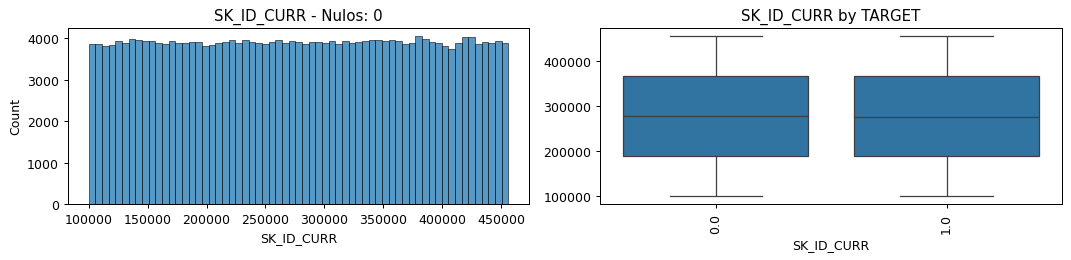

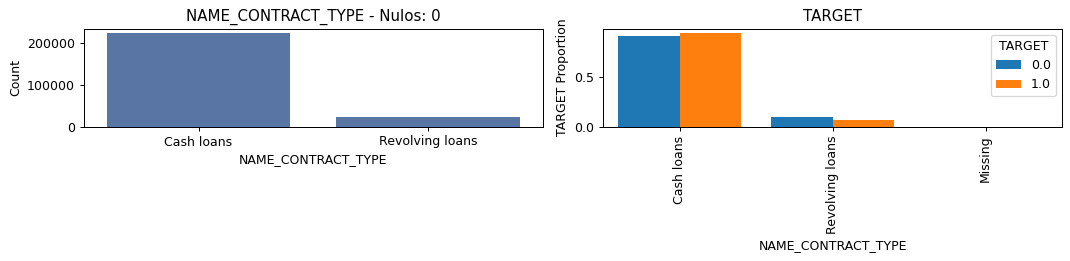

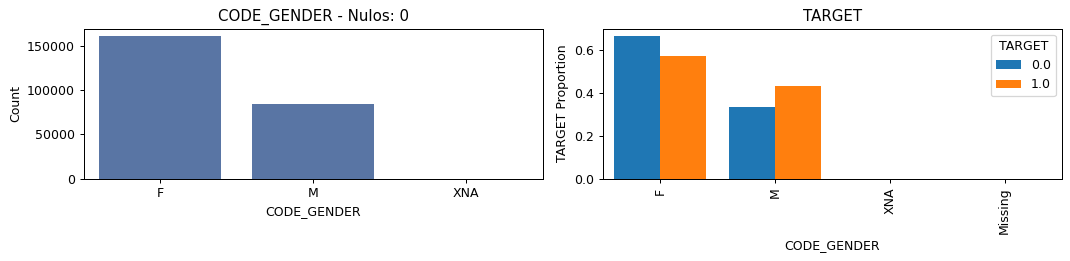

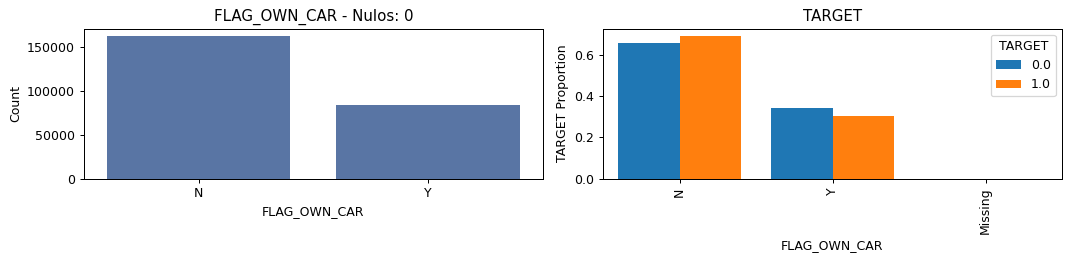

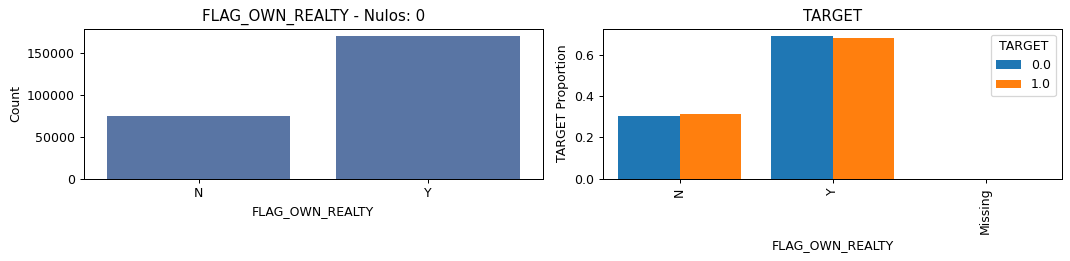

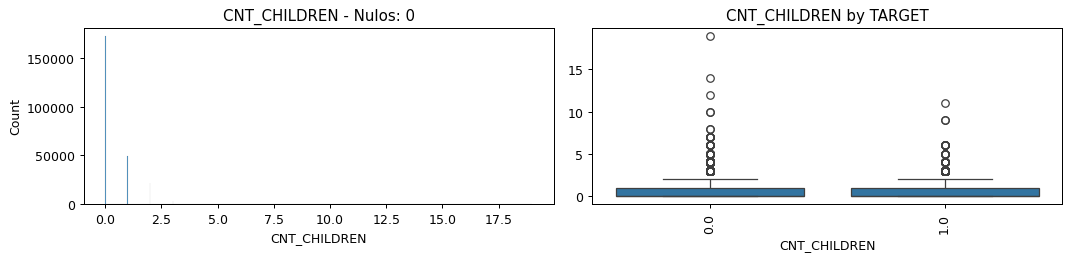

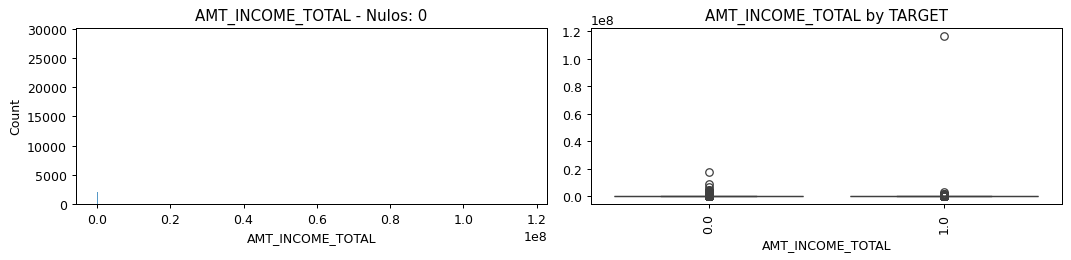

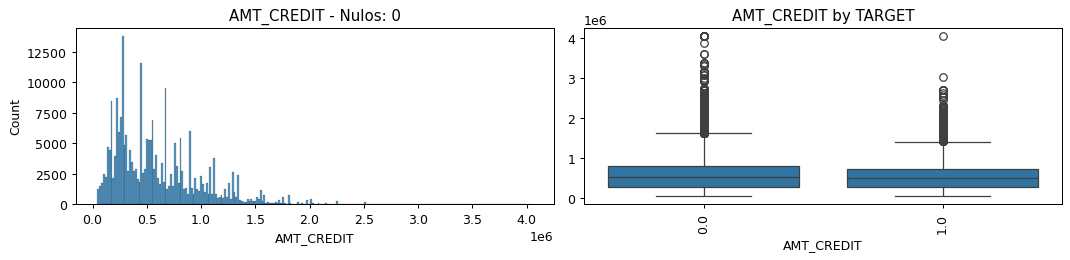

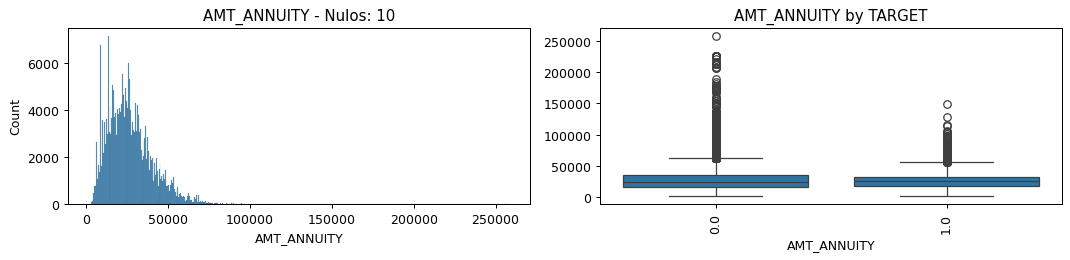

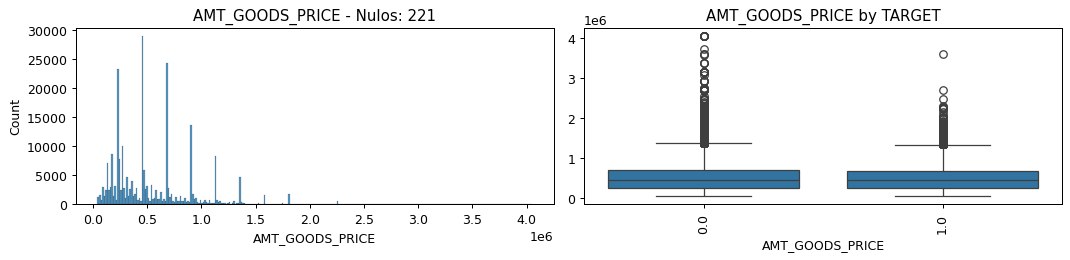

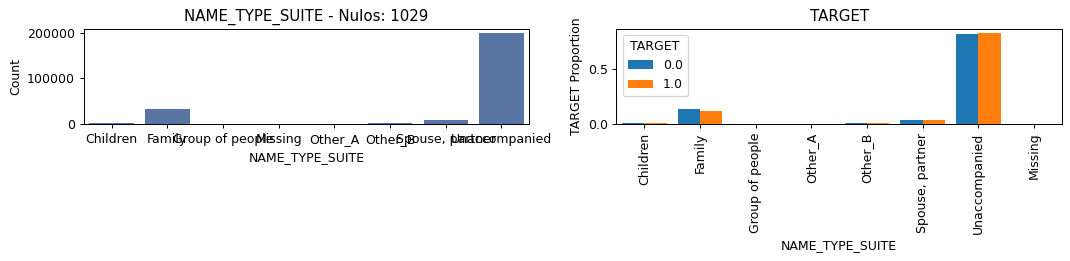

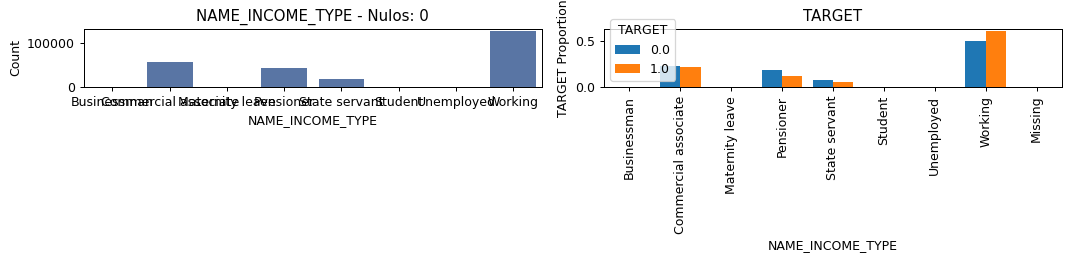

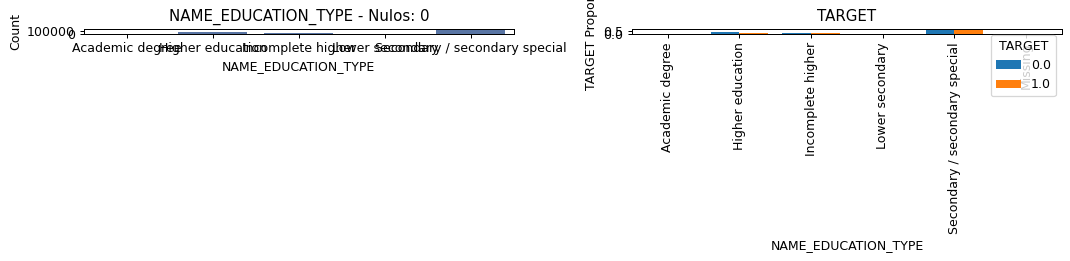

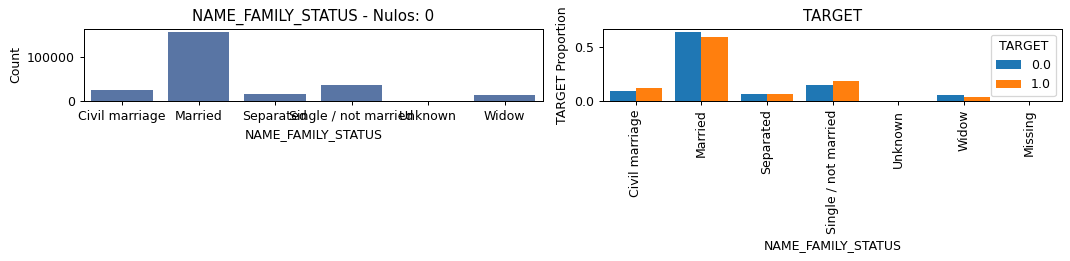

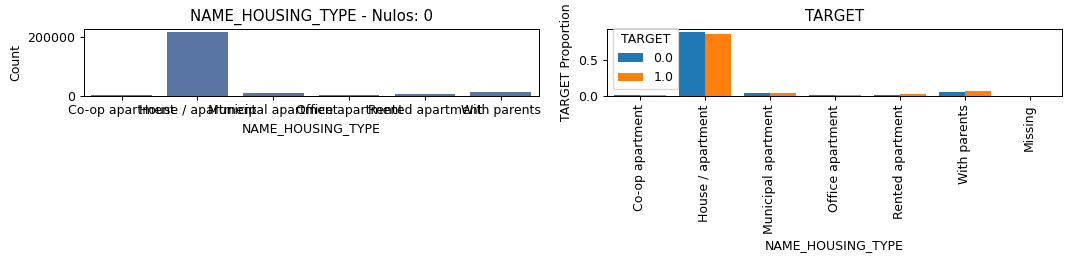

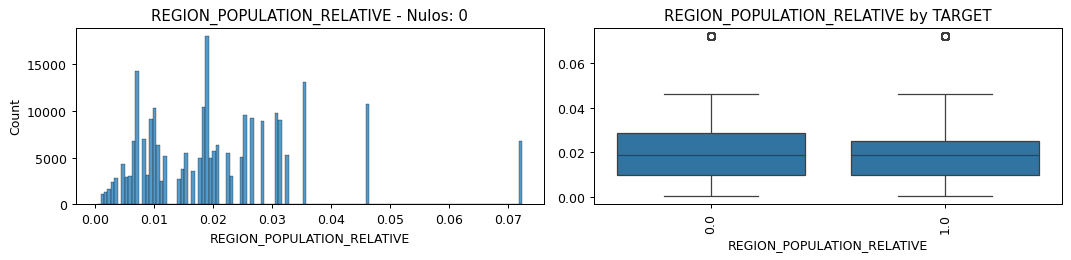

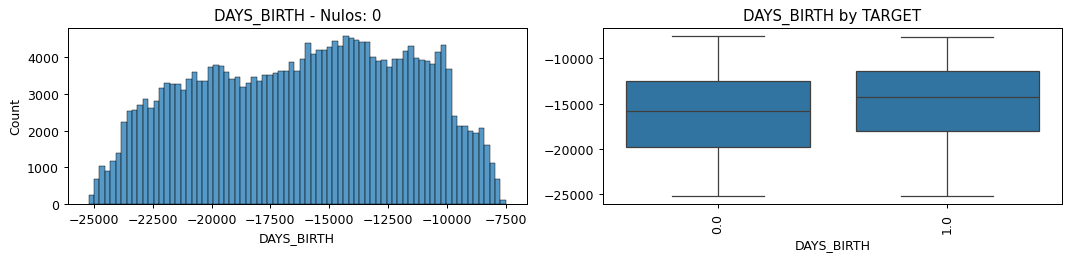

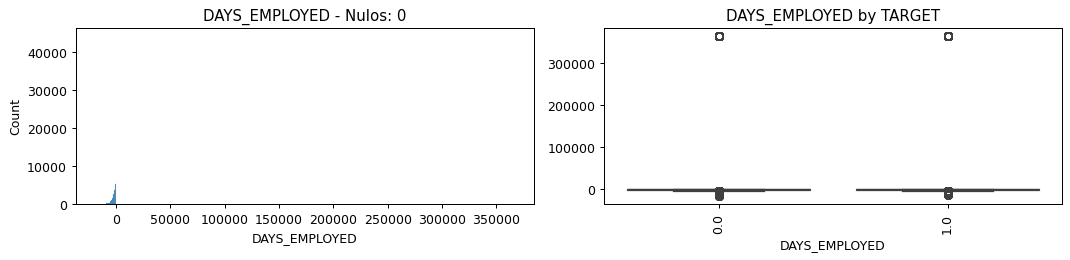

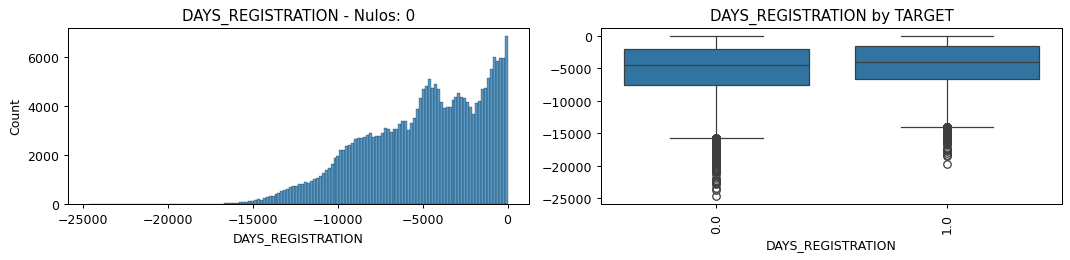

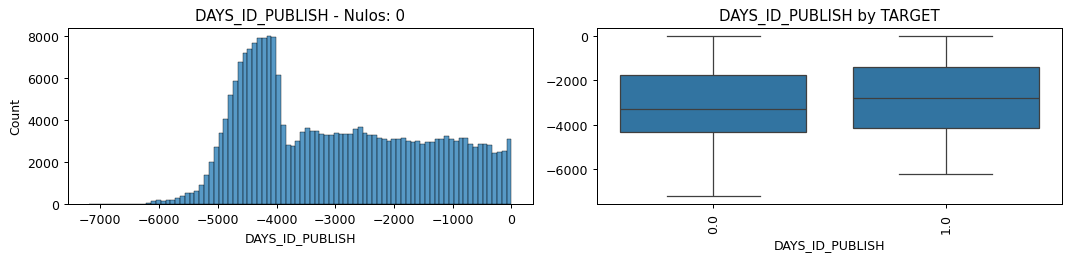

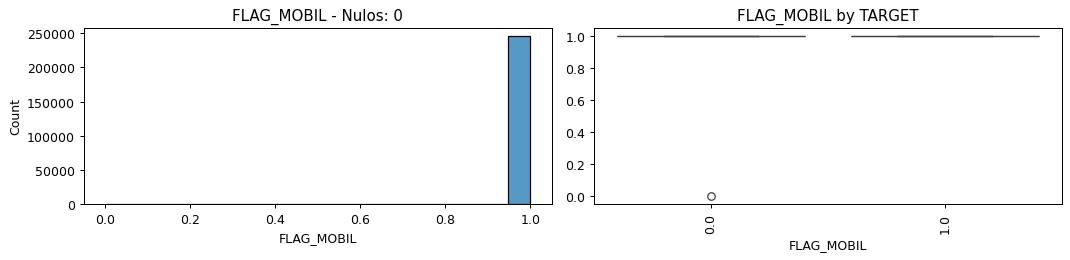

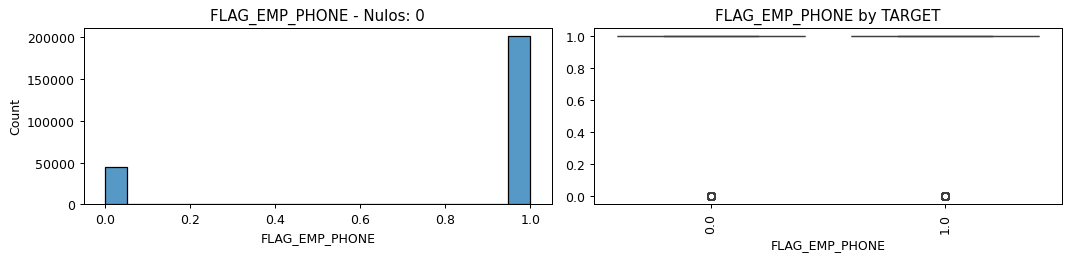

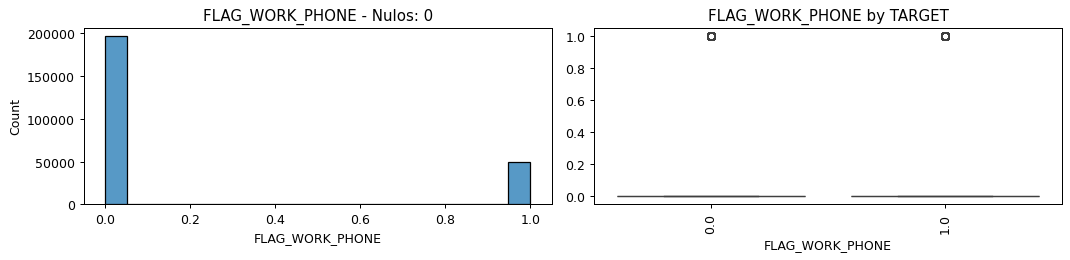

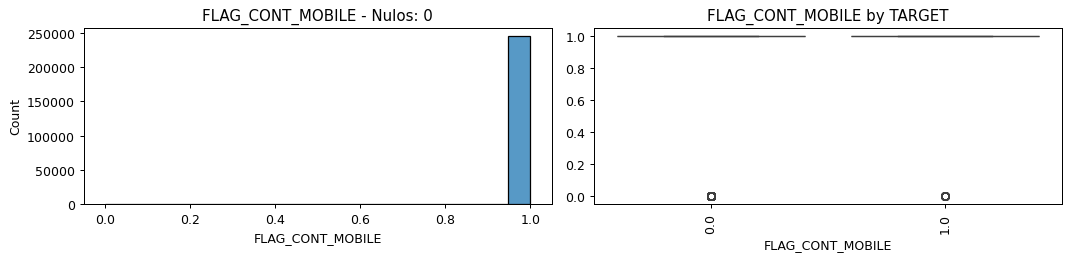

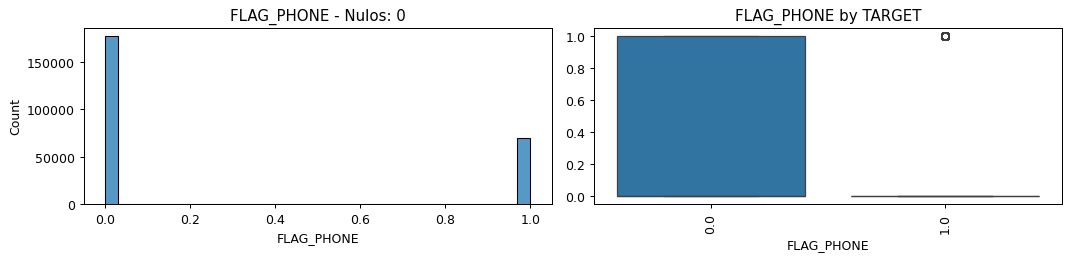

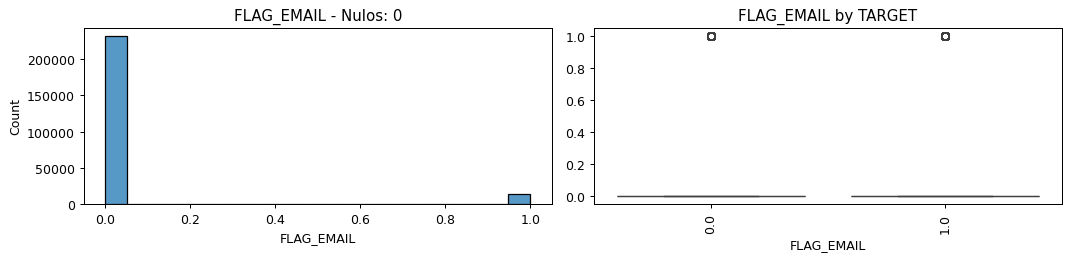

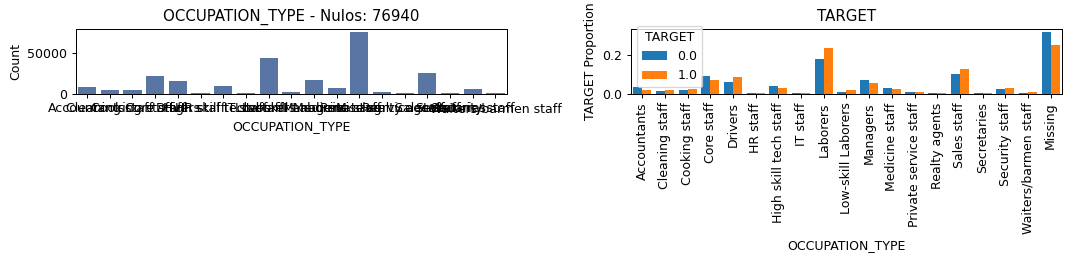

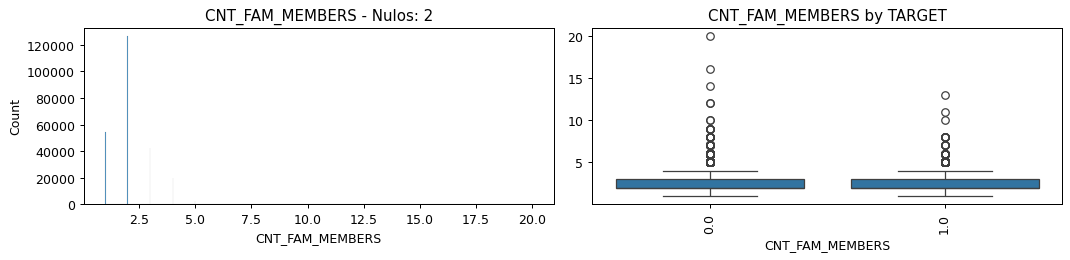

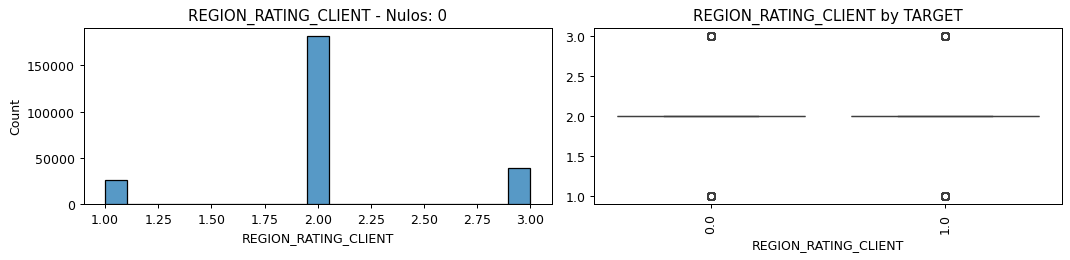

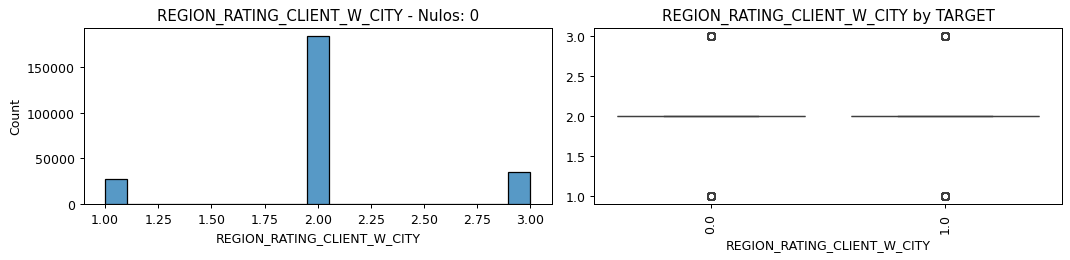

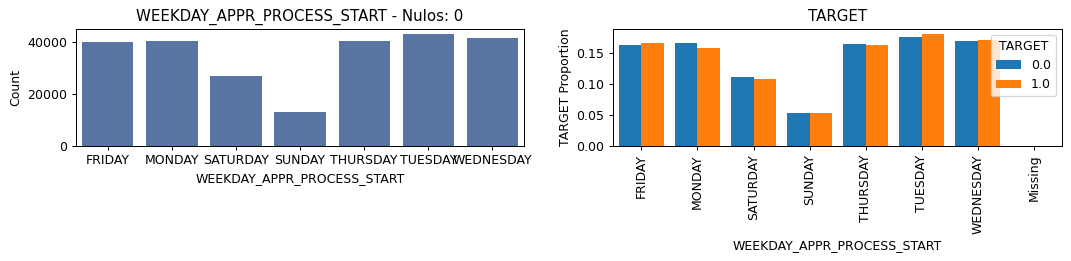

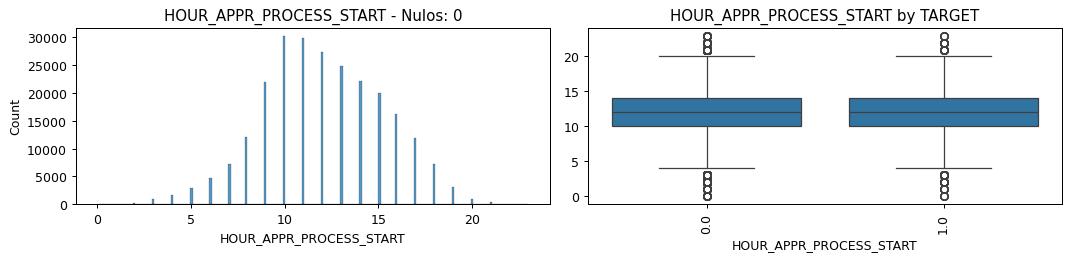

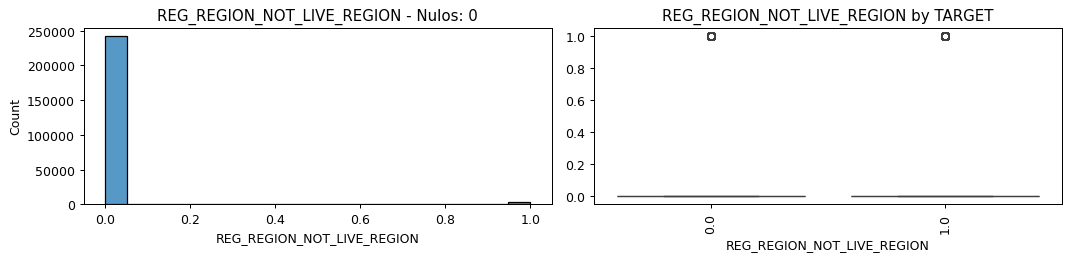

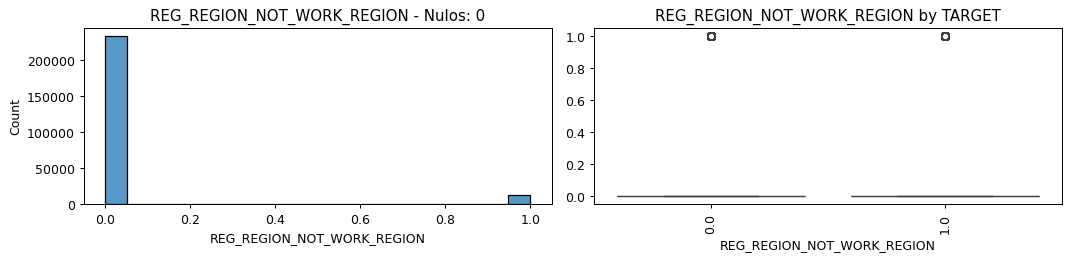

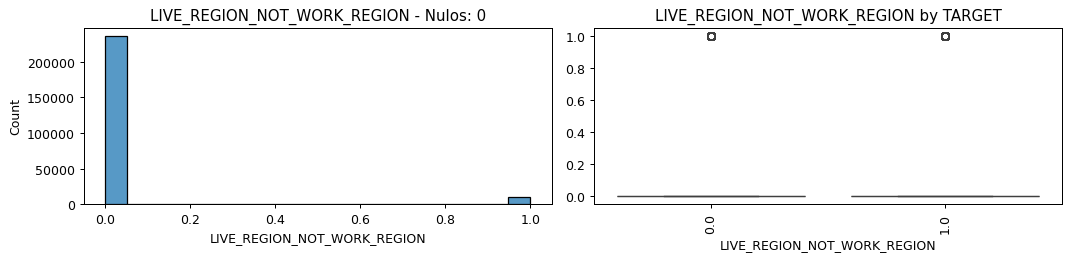

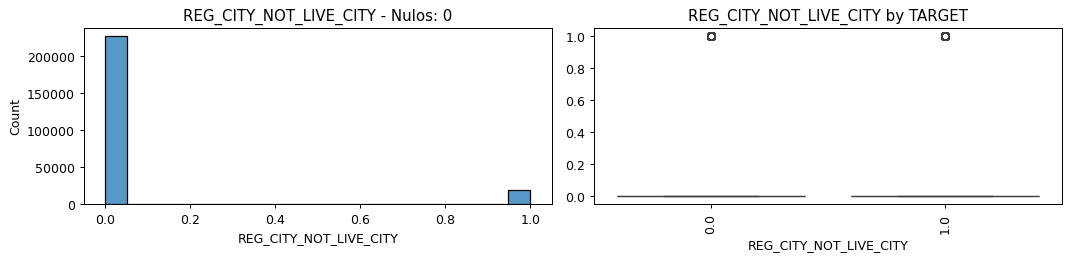

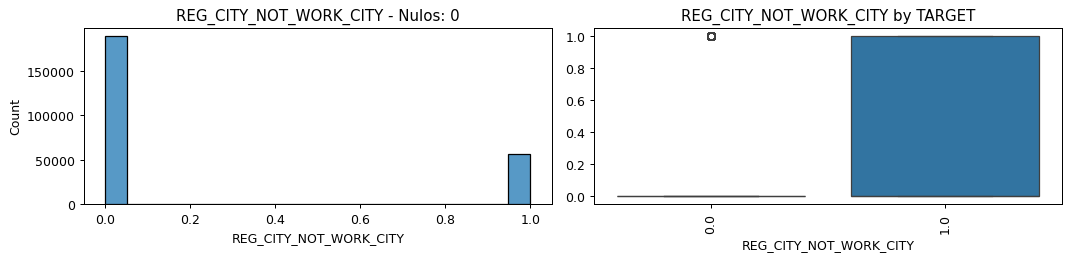

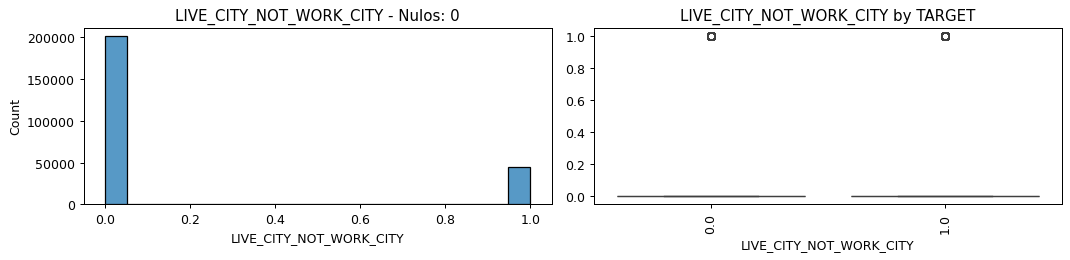

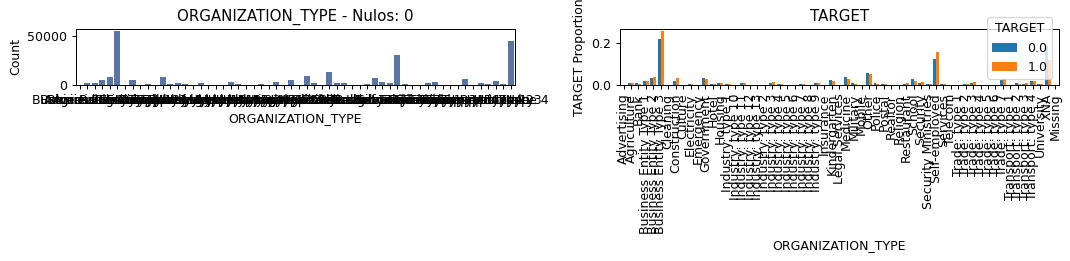

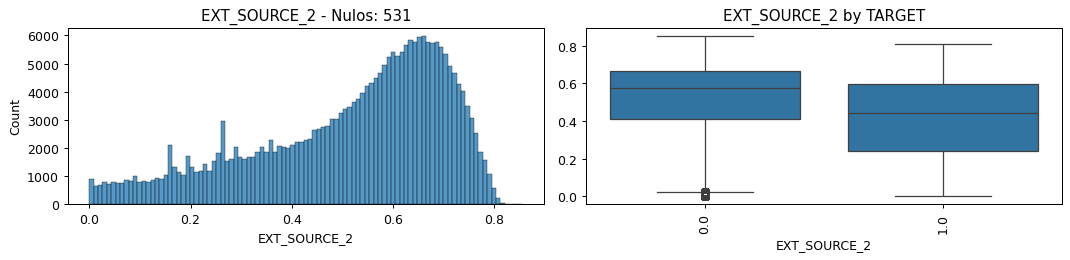

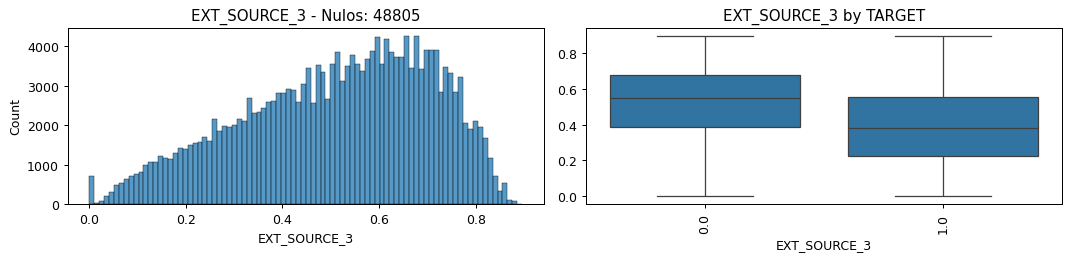

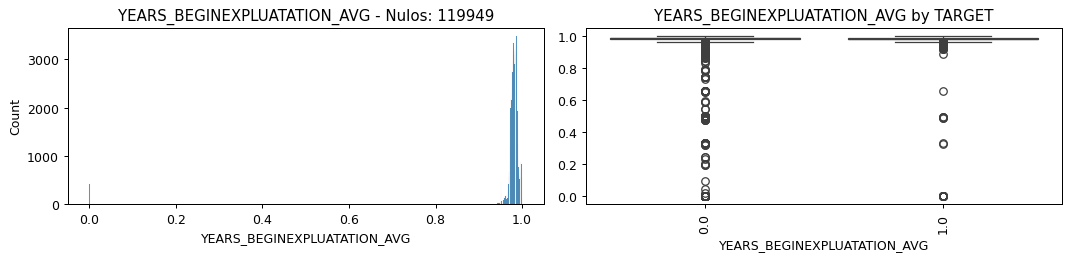

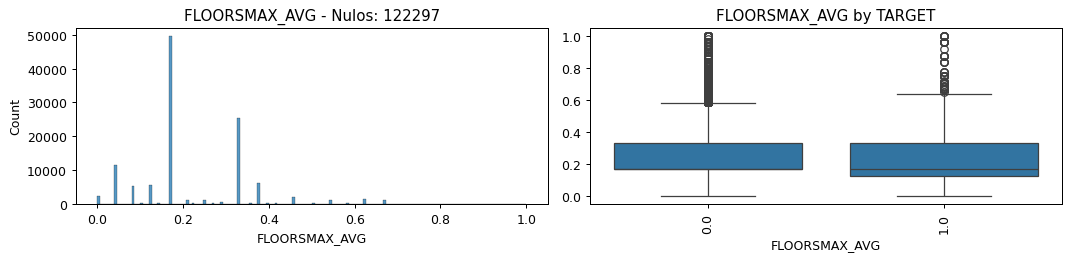

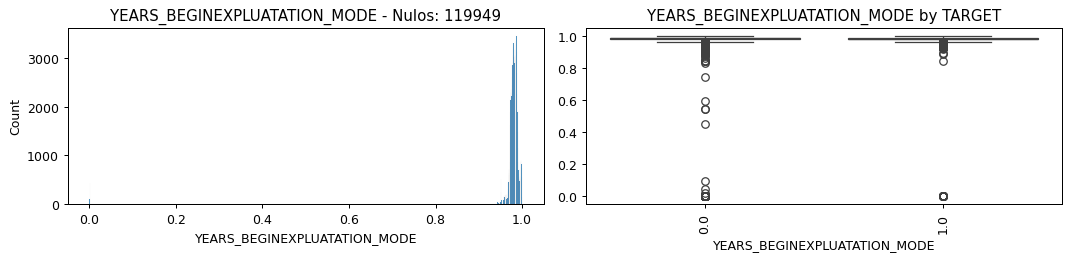

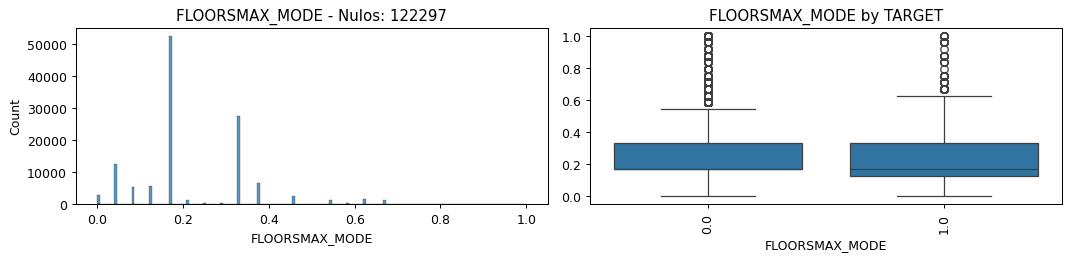

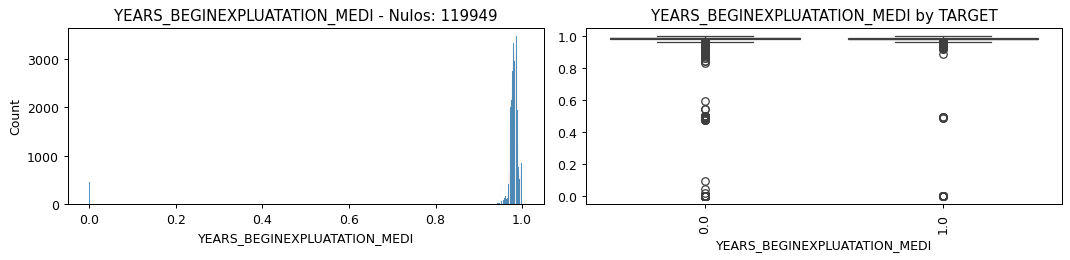

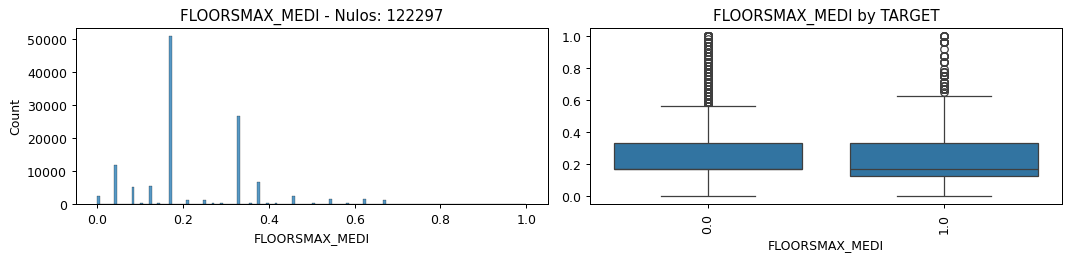

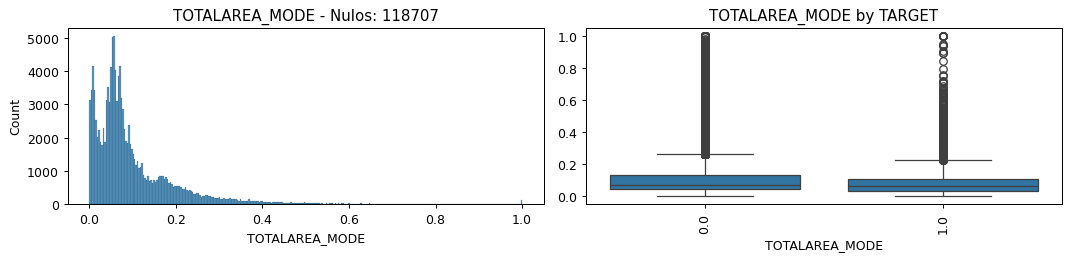

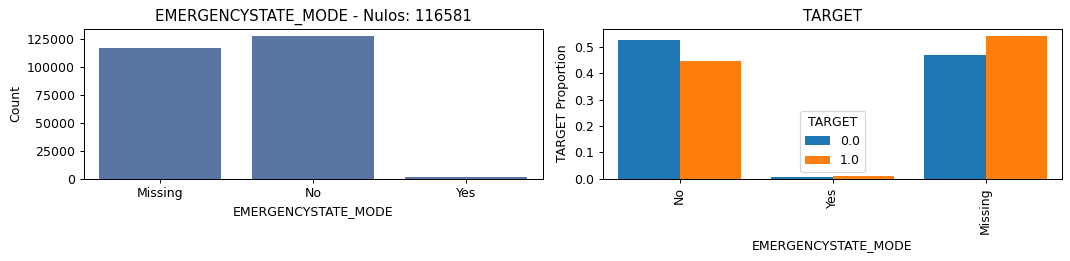

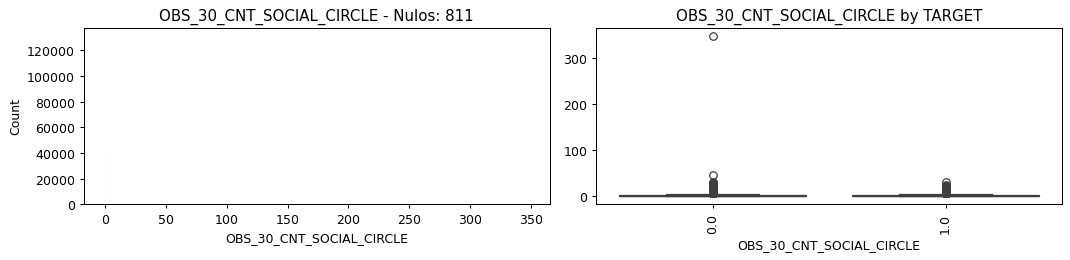

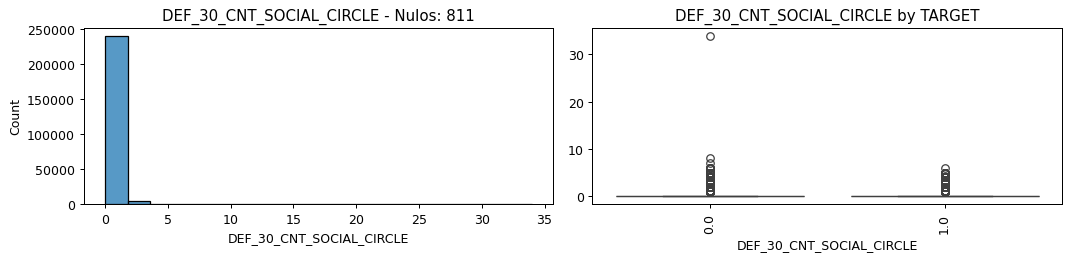

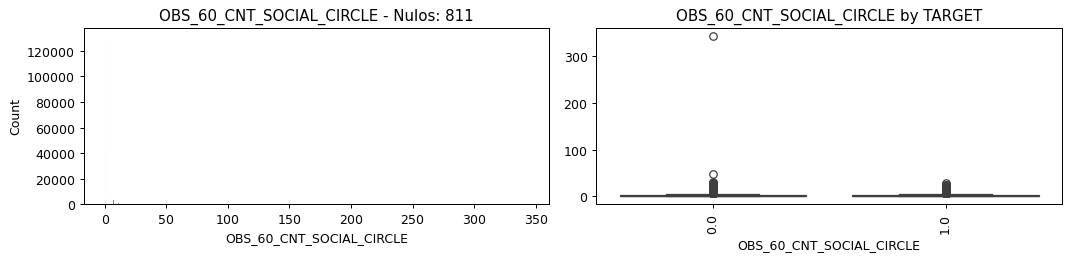

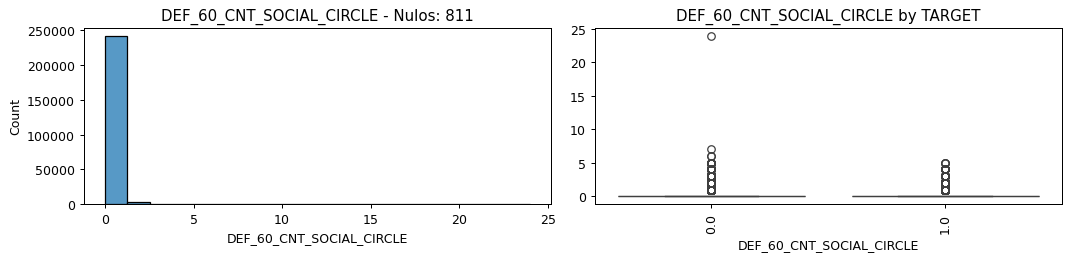

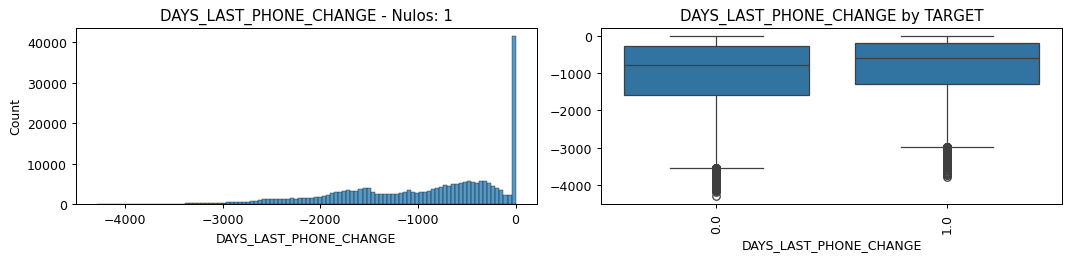

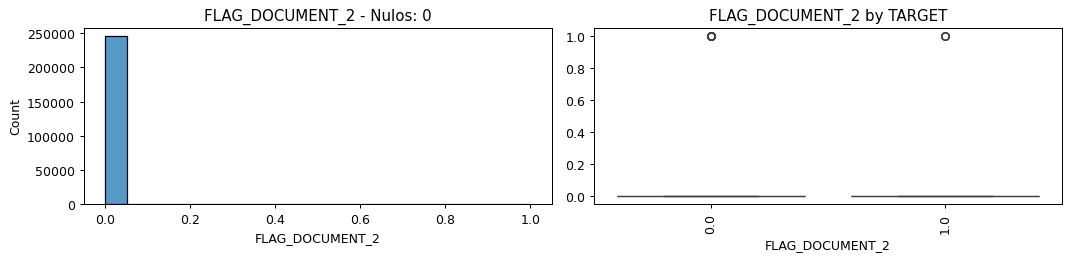

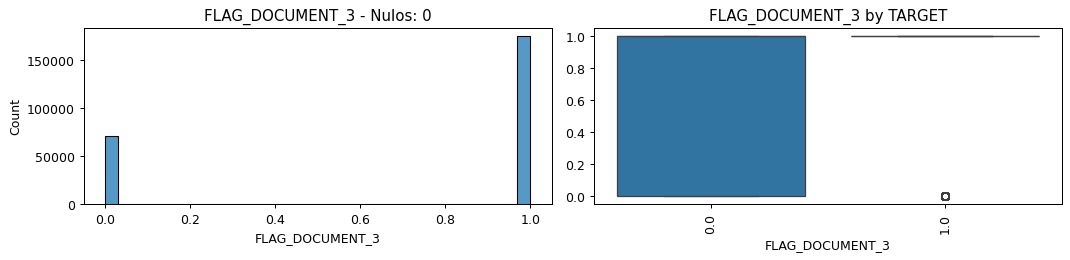

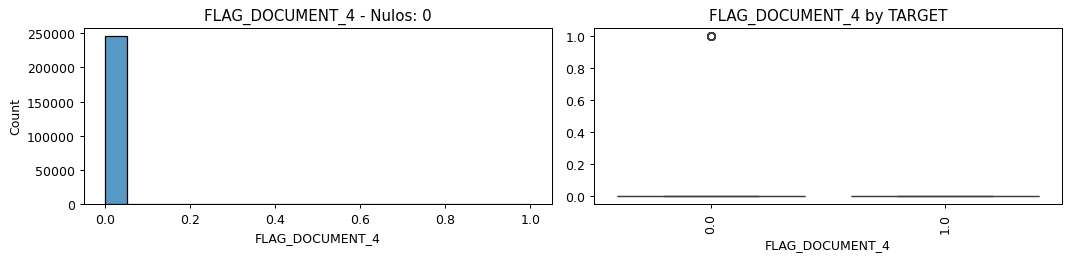

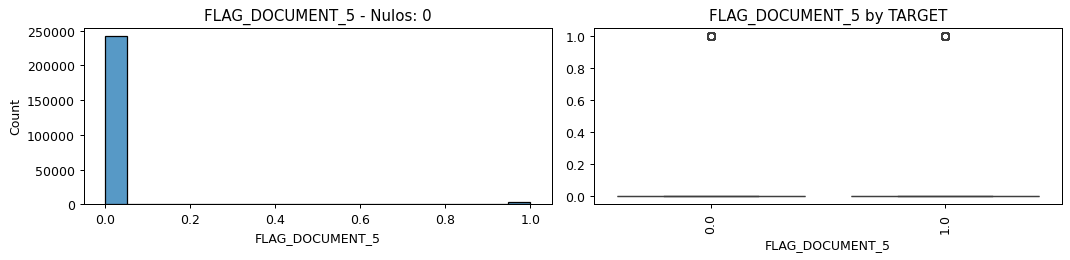

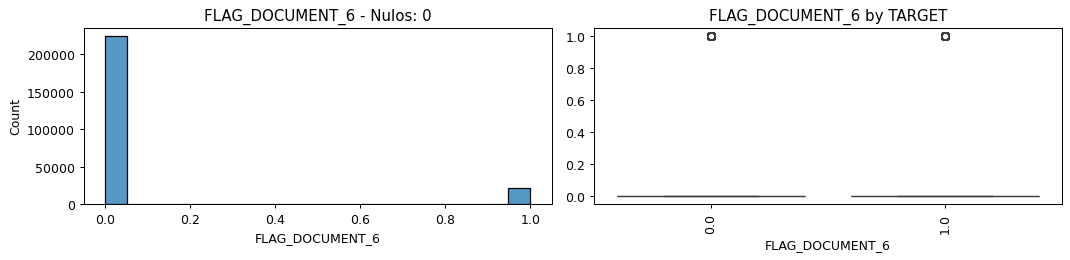

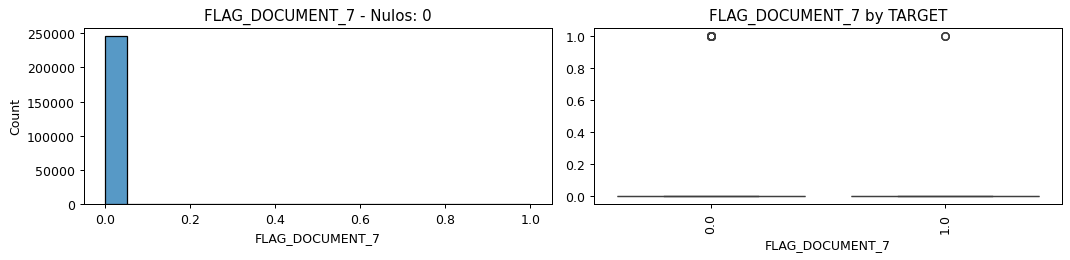

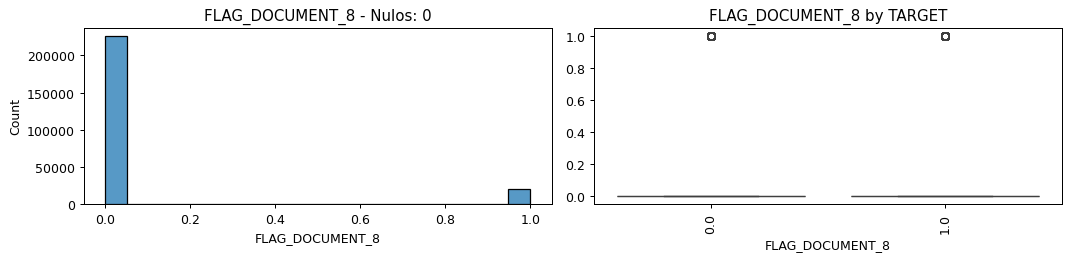

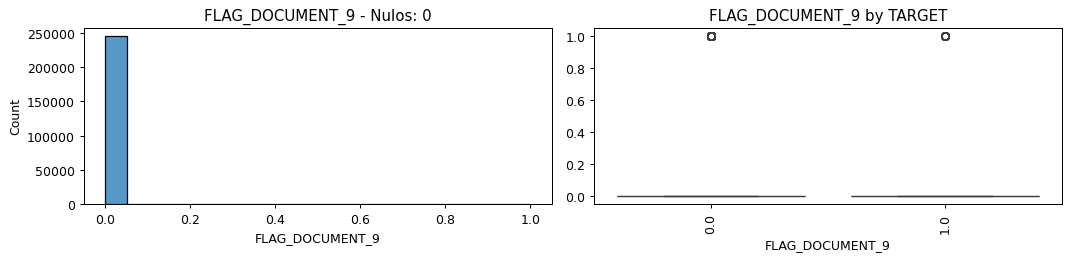

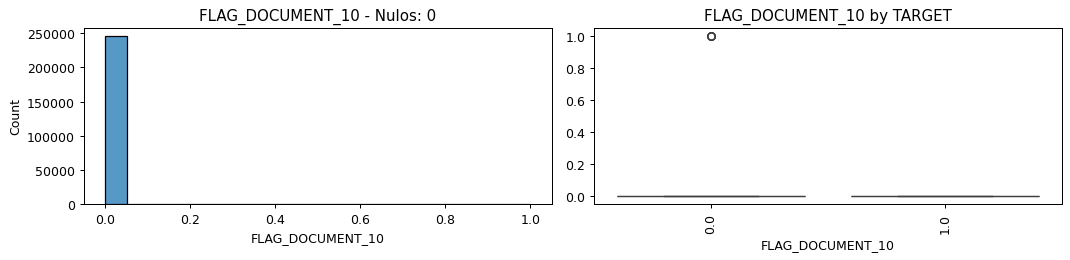

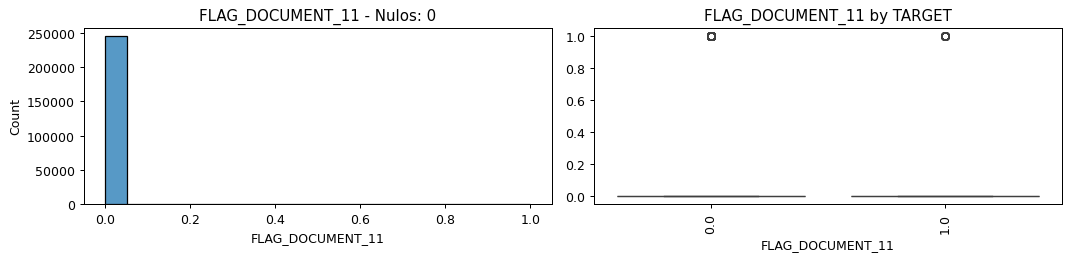

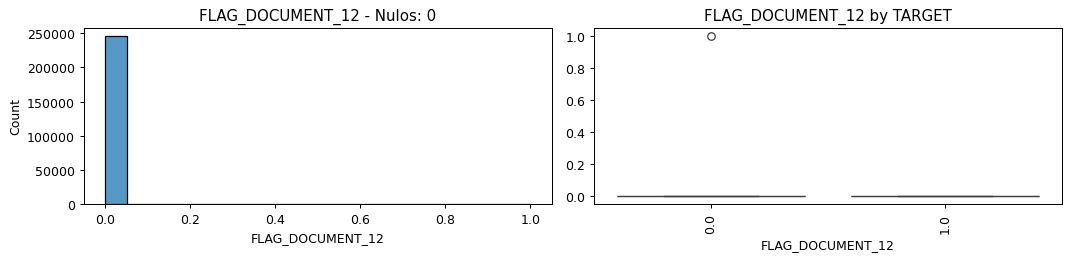

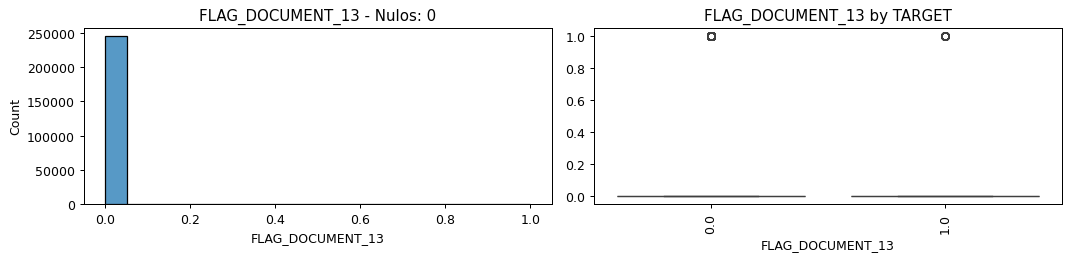

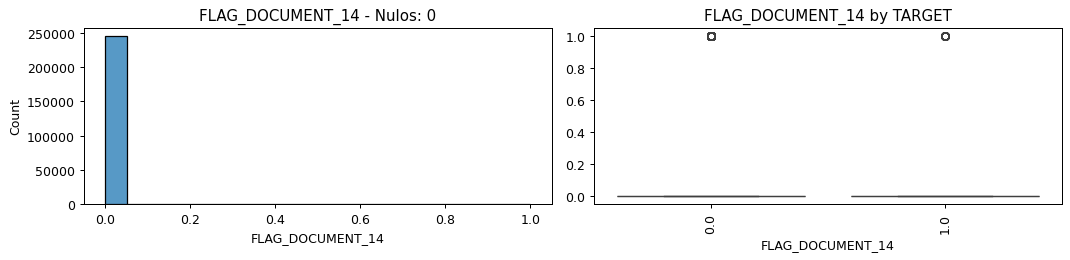

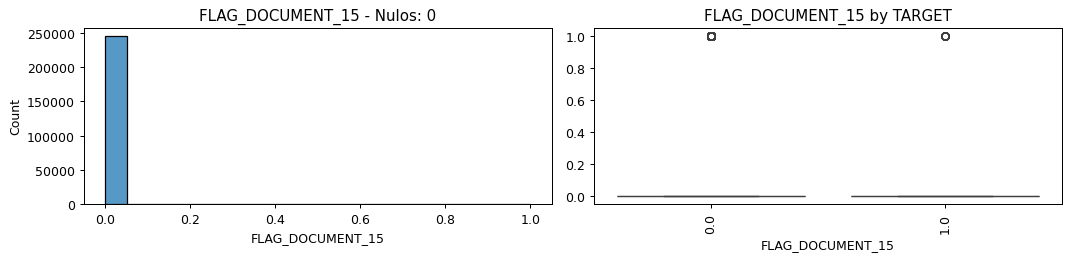

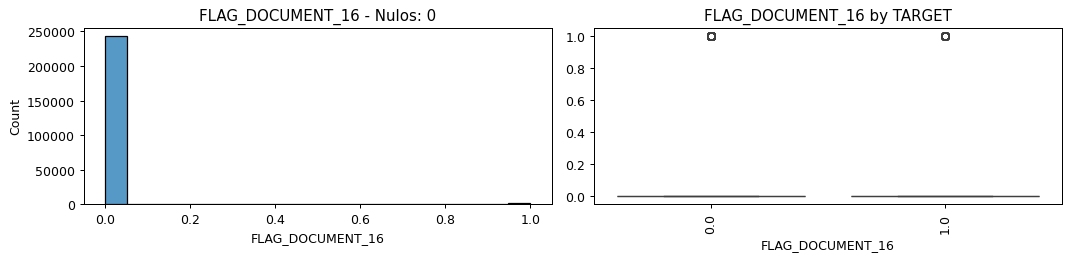

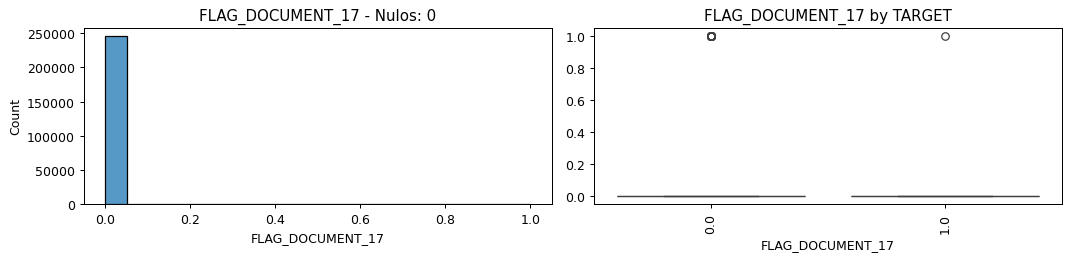

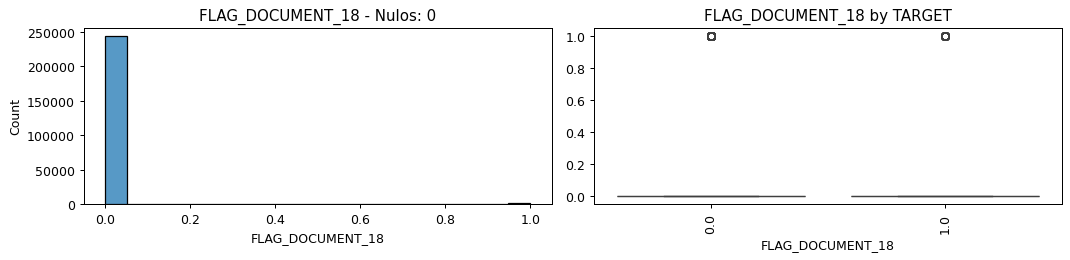

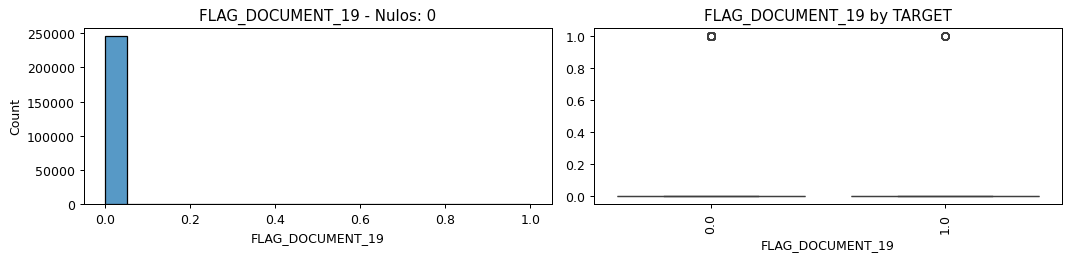

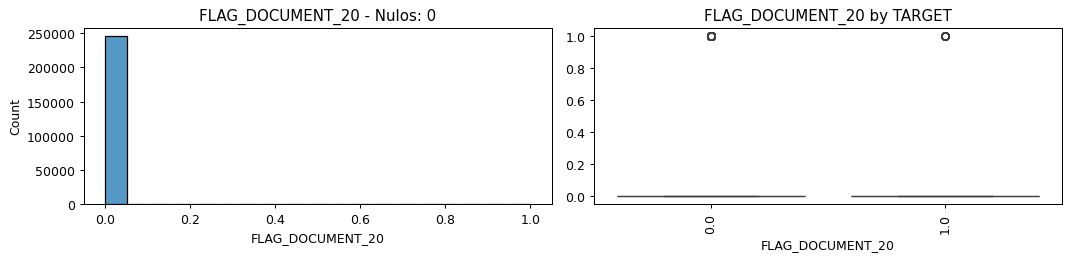

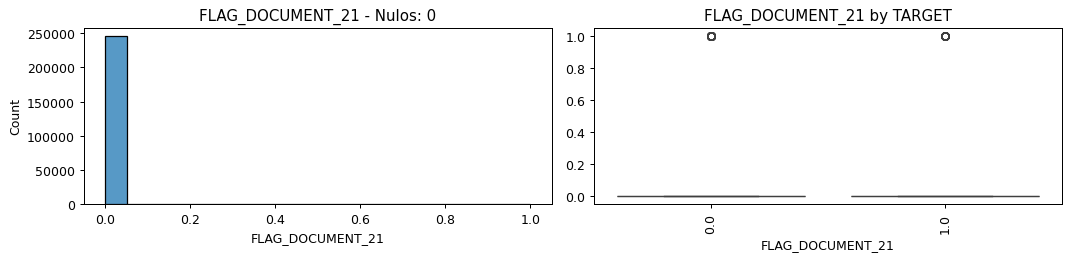

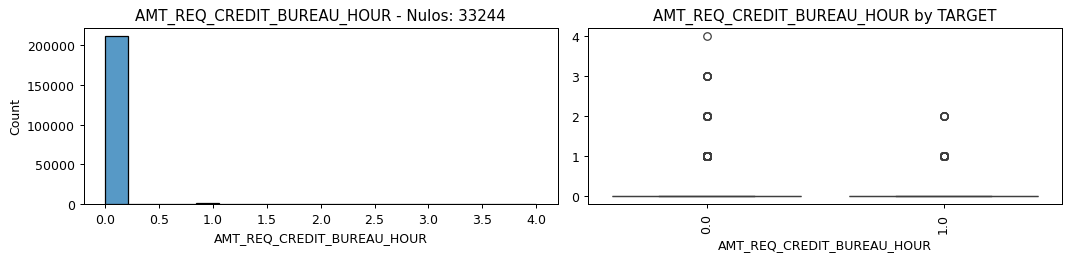

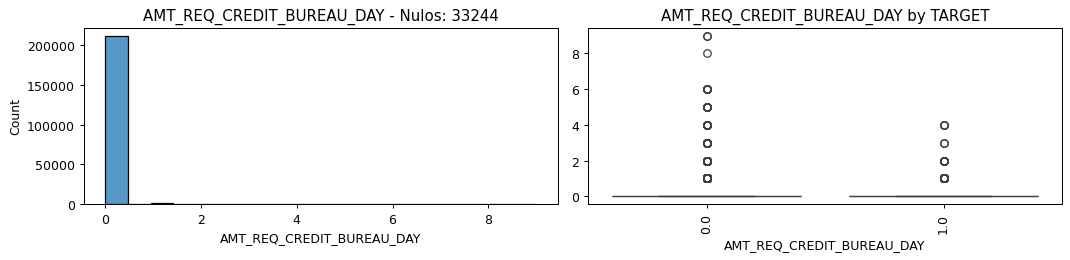

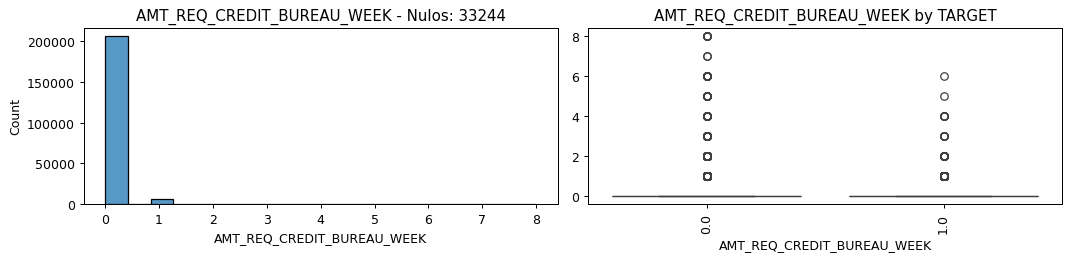

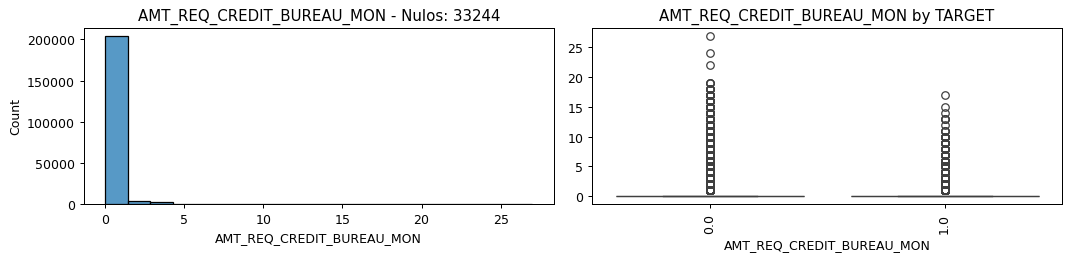

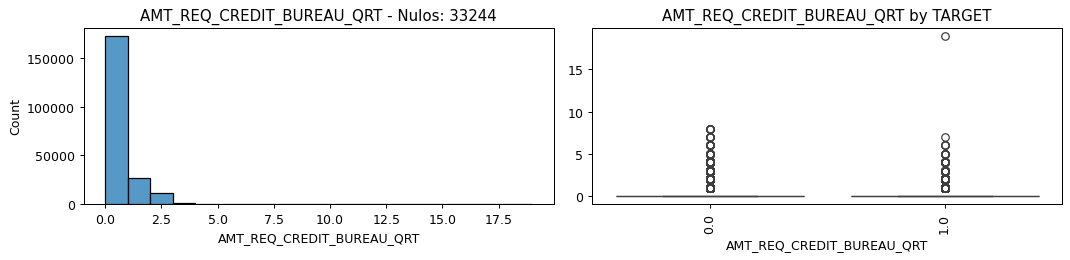

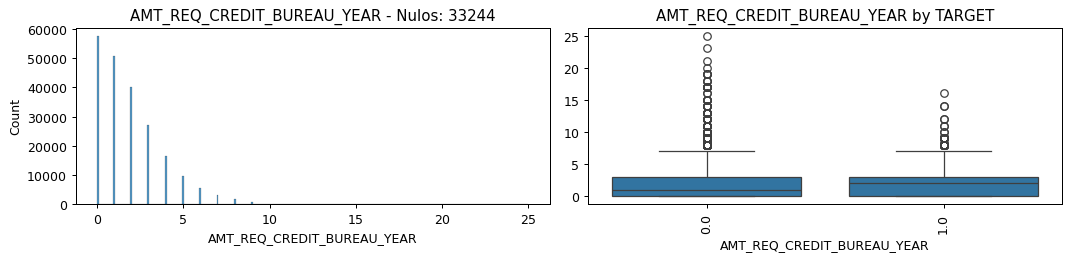

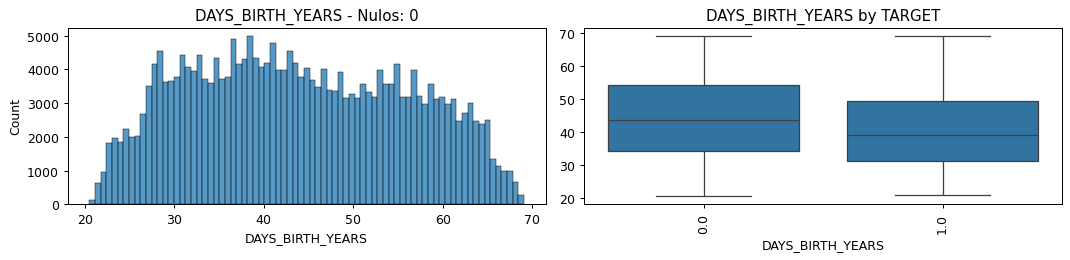

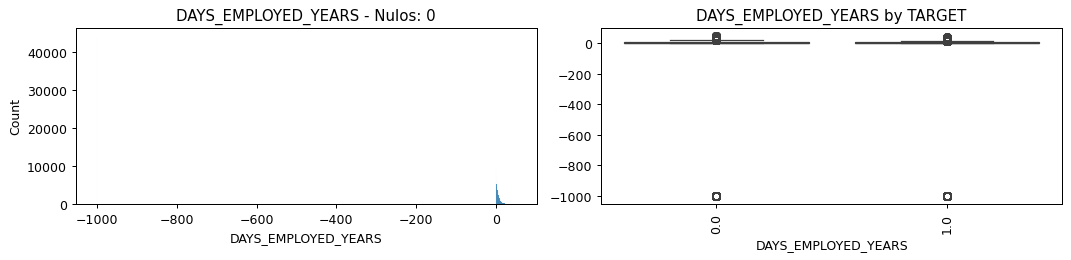

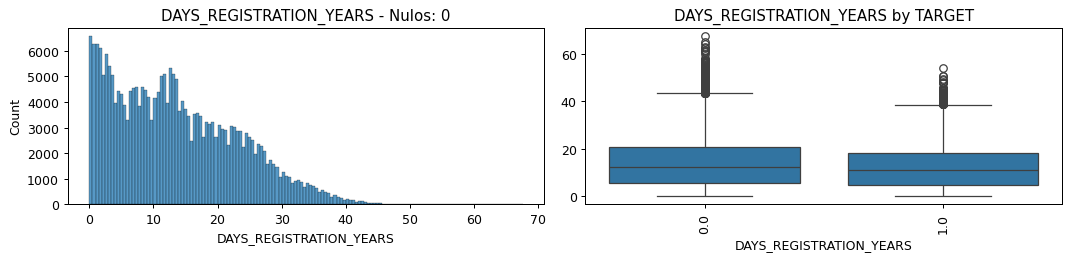

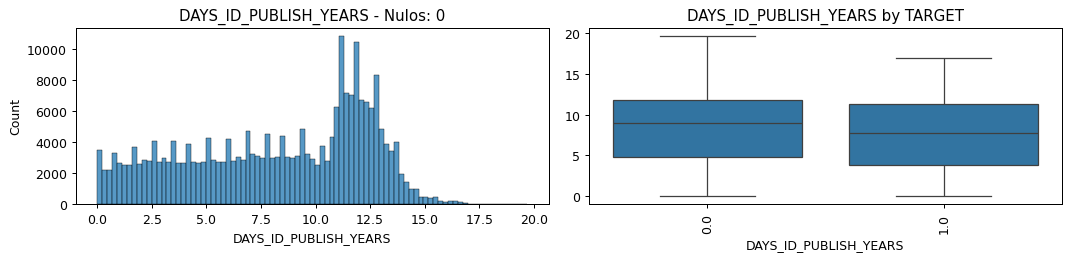

In [24]:
 def plot_feature(df, col_name, isContinuous, target):
    """
    Visualiza una variable con y sin segmentación según la variable objetivo.
    - df: DataFrame
    - col_name: Nombre de la variable
    - isContinuous: True si la variable es continua, False si es categórica
    - target: Variable objetivo (e.g., 'TARGET')
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        # Manejo de columnas categóricas con valores nulos
        if df[col_name].dtype.name == 'category':
            # Añadir la categoría "Missing" si es necesario
            if "Missing" not in df[col_name].cat.categories:
                df[col_name] = df[col_name].cat.add_categories("Missing")
        # Reemplazar nulos con "Missing"
        categories = df[col_name].fillna("Missing").unique()
        sns.countplot(x=df[col_name].fillna("Missing"), 
                      order=sorted(categories, key=str), 
                      color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{col_name} - Nulos: {count_null}')
    plt.xticks(rotation=90)

    if isContinuous:
        sns.boxplot(x=target, y=col_name, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(f'{col_name} by {target}')
    else:
        # Agrupar y calcular proporciones
        data = df[col_name].fillna("Missing").groupby(df[target]).value_counts(normalize=True).reset_index(name='proportion')
        sns.barplot(x=col_name, y='proportion', hue=target, data=data, saturation=1, ax=ax2)
        ax2.set_ylabel(f'{target} Proportion')
        ax2.set_title(f'{target}')
        plt.xticks(rotation=90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
 # Ignorar advertencias innecesarias
import warnings
warnings.filterwarnings('ignore')

# Recorrer todas las columnas en el conjunto de entrenamiento
for col in list(data_train.columns):
    if (data_train[col].dtype in ['float64', 'int64']) and (col != 'TARGET'):
        # Graficar variables continuas
        plot_feature(data_train, col_name=col, isContinuous=True, target='TARGET')
    elif col != 'TARGET':
        # Graficar variables categóricas
        plot_feature(data_train, col_name=col, isContinuous=False, target='TARGET')


Estos son los gráficos más relevantes del análisis exploratorio, seleccionados por su aporte significativo a la interpretación de las relaciones entre las variables del dataset y el objetivo (TARGET).

##### __Gráfico de NAME_CONTRACT_TYPE:__

- Los préstamos de tipo "Cash loans" son predominantes, y parecen tener una mayor proporción de incumplimiento (TARGET = 1) en comparación con "Revolving loans".

- Interpretación: Este comportamiento sugiere que el tipo de contrato es un factor relevante en el análisis de riesgo crediticio.

##### __Gráfico de AMT_CREDIT:__

- La mayoría de los créditos se concentran en rangos bajos (por ejemplo, menos de 1 millón). Sin embargo, hay valores extremos significativos que podrían distorsionar los análisis si no se manejan adecuadamente.

##### __Gráfico de DAYS_BIRTH:__

- Los solicitantes más jóvenes parecen tener una mayor proporción de incumplimiento (TARGET = 1) en comparación con los más mayores.

- Interpretación: La edad podría estar correlacionada con el nivel de riesgo, lo cual es importante para los modelos de predicción.

##### __Grafico de EXT_SOURCE_3:__

- Esta variable muestra una correlación visible con el objetivo TARGET. Aquellos con valores más altos de EXT_SOURCE_3 tienen menos probabilidad de pertenecer a la categoría 1.0 del TARGET. Esto podría sugerir que esta fuente externa de datos predice un menor riesgo.

- Valores más altos en EXT_SOURCE_3 están asociados con clientes de menor riesgo (TARGET = 0). Este comportamiento puede ser indicativo de una métrica de confiabilidad proporcionada por una fuente externa.

##### __Grafico de YEARS_BEGINEXPLUATATION_AVG:__

- Esta variable muestra una distribución concentrada hacia valores altos, aunque no parece tener una separación clara respecto al TARGET.

- Aunque los valores altos de esta variable son predominantes, no parece haber una relación visible o útil para discriminar entre las categorías del TARGET.

##### __Grafico de EMERGENCYSTATE_MODE:__

- Hay una proporción notable de valores faltantes, y aunque los clientes en la categoría Missing o No parecen tener comportamientos diferentes respecto al TARGET, la variable en sí misma no muestra una gran diferenciación.

- Esta variable tiene muchos valores faltantes, y su impacto en la categorización del TARGET no es evidente, lo que podría reducir su importancia en modelos predictivos.

## Tratamiento de las variables continuas 

### 1. Identificar variables continuas

In [26]:

list_var_continuous = list(data_train.select_dtypes(['float64', 'int64']).columns)
list_var_continuous.remove('TARGET')  # Excluir la variable objetivo

print("Variables continuas identificadas:")
print(list_var_continuous)



Variables continuas identificadas:
['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'F

###  2. Tratamiento de valores nulos

In [27]:
pd_missing_continuous = data_train[list_var_continuous].isnull().sum()
pd_missing_continuous = pd.DataFrame({
    'nulos': pd_missing_continuous,
    'porcentaje': (pd_missing_continuous / len(data_train) * 100).round(2)
}).sort_values(by='nulos', ascending=False)

print("\nValores missing en variables continuas:")
print(pd_missing_continuous)


Valores missing en variables continuas:
                               nulos  porcentaje
FLOORSMAX_AVG                 122297       49.71
FLOORSMAX_MODE                122297       49.71
FLOORSMAX_MEDI                122297       49.71
YEARS_BEGINEXPLUATATION_AVG   119949       48.76
YEARS_BEGINEXPLUATATION_MODE  119949       48.76
YEARS_BEGINEXPLUATATION_MEDI  119949       48.76
TOTALAREA_MODE                118707       48.25
EXT_SOURCE_3                   48805       19.84
AMT_REQ_CREDIT_BUREAU_YEAR     33244       13.51
AMT_REQ_CREDIT_BUREAU_QRT      33244       13.51
AMT_REQ_CREDIT_BUREAU_MON      33244       13.51
AMT_REQ_CREDIT_BUREAU_WEEK     33244       13.51
AMT_REQ_CREDIT_BUREAU_DAY      33244       13.51
AMT_REQ_CREDIT_BUREAU_HOUR     33244       13.51
OBS_30_CNT_SOCIAL_CIRCLE         811        0.33
OBS_60_CNT_SOCIAL_CIRCLE         811        0.33
DEF_30_CNT_SOCIAL_CIRCLE         811        0.33
DEF_60_CNT_SOCIAL_CIRCLE         811        0.33
EXT_SOURCE_2                

### 3. Análisis de correlaciones


Matriz de correlación de las variables continuas:


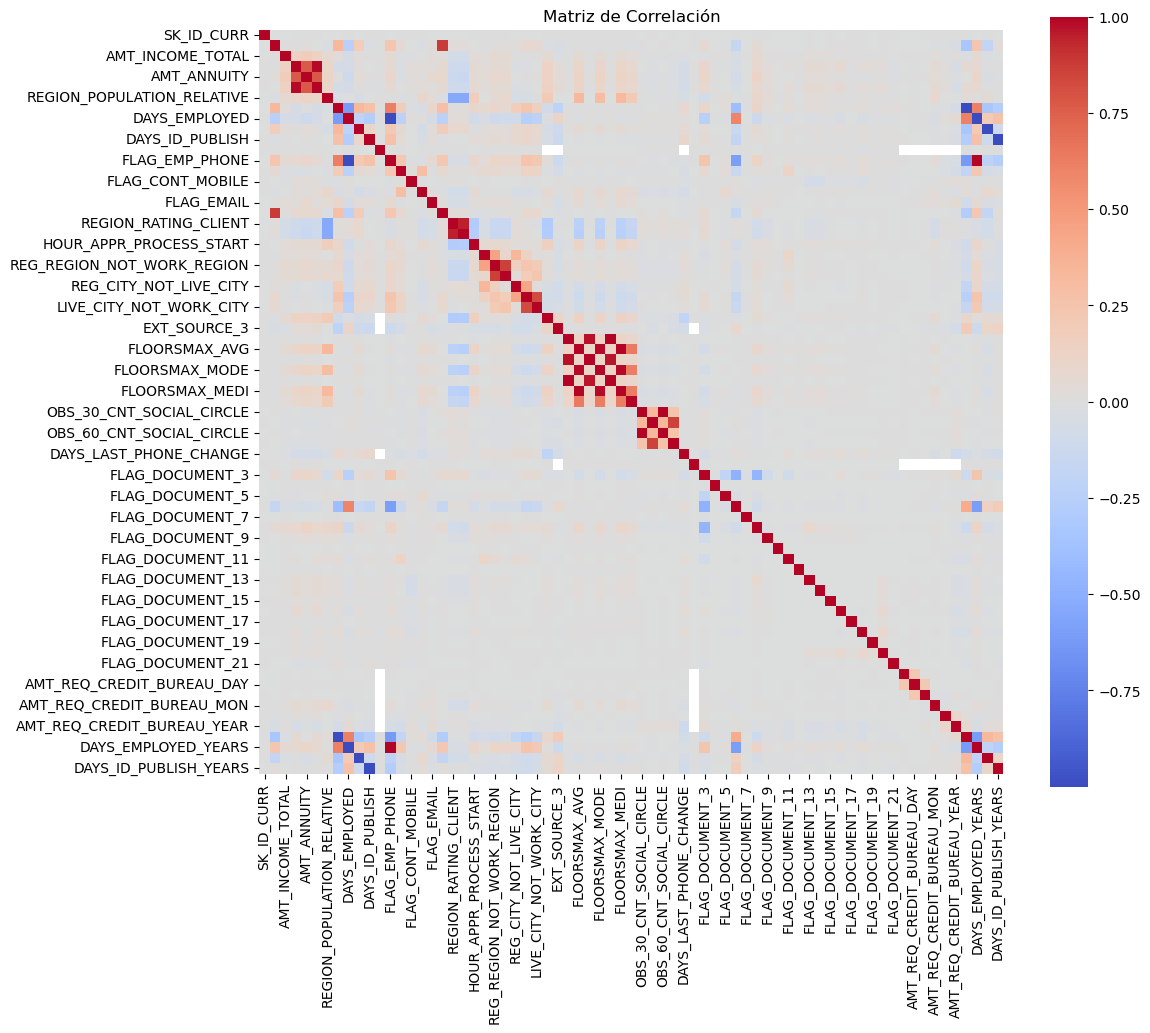

In [28]:

print("\nMatriz de correlación de las variables continuas:")
plt.figure(figsize=(12, 10))
sns.heatmap(
    data_train[list_var_continuous].corr(),
    annot=False,
    cmap='coolwarm',
    center=0,
    square=True
)
plt.title("Matriz de Correlación")
plt.show()

##### **Variables con alta correlación positiva:**
- FLOORSMAX_AVG, FLOORSMAX_MODE, y FLOORSMAX_MEDI tienen una fuerte correlación positiva entre sí. Esto indica que estas variables están estrechamente relacionadas y probablemente representan aspectos similares del dataset, como la altura máxima de los edificios.

- Similarmente, YEARS_BEGINEXPLUATATION_AVG, YEARS_BEGINEXPLUATATION_MODE, y YEARS_BEGINEXPLUATATION_MEDI presentan una alta correlación positiva. Estas variables parecen estar relacionadas con la antigüedad o el tiempo desde el inicio de explotación de un bien.


##### **Relaciones moderadas:**
- Existe una correlación moderada entre AMT_ANNUITY y AMT_CREDIT. Este resultado es coherente, ya que el monto del crédito otorgado suele estar vinculado al monto de la anualidad a pagar.

- DAYS_REGISTRATION_YEARS también muestra cierta relación con DAYS_ID_PUBLISH_YEARS, lo que podría sugerir que estos datos temporalmente relacionados tienen patrones comunes.

##### **Variables independientes o con baja correlación:**
- Variables como DAYS_EMPLOYED_YEARS y REGION_POPULATION_RELATIVE muestran una correlación muy baja con la mayoría de las otras variables, indicando que pueden aportar información única y no redundante al modelo.

### 4. Análisis de outliers

In [29]:

def detect_outliers(df, variable, threshold=3):
    """
    Detecta outliers usando el método Z-Score.
    """
    z_scores = (df[variable] - df[variable].mean()) / df[variable].std()
    return df[(z_scores.abs() > threshold)]

print("\nAnálisis de outliers:")
for col in list_var_continuous:
    outliers = detect_outliers(data_train, col)
    print(f"{col}: {len(outliers)} outliers detectados.")


Análisis de outliers:
SK_ID_CURR: 0 outliers detectados.
CNT_CHILDREN: 3366 outliers detectados.
AMT_INCOME_TOTAL: 208 outliers detectados.
AMT_CREDIT: 2619 outliers detectados.
AMT_ANNUITY: 2363 outliers detectados.
AMT_GOODS_PRICE: 3321 outliers detectados.
REGION_POPULATION_RELATIVE: 6729 outliers detectados.
DAYS_BIRTH: 0 outliers detectados.
DAYS_EMPLOYED: 0 outliers detectados.
DAYS_REGISTRATION: 613 outliers detectados.
DAYS_ID_PUBLISH: 0 outliers detectados.
FLAG_MOBIL: 1 outliers detectados.
FLAG_EMP_PHONE: 0 outliers detectados.
FLAG_WORK_PHONE: 0 outliers detectados.
FLAG_CONT_MOBILE: 462 outliers detectados.
FLAG_PHONE: 0 outliers detectados.
FLAG_EMAIL: 13957 outliers detectados.
CNT_FAM_MEMBERS: 3155 outliers detectados.
REGION_RATING_CLIENT: 0 outliers detectados.
REGION_RATING_CLIENT_W_CITY: 0 outliers detectados.
HOUR_APPR_PROCESS_START: 491 outliers detectados.
REG_REGION_NOT_LIVE_REGION: 3695 outliers detectados.
REG_REGION_NOT_WORK_REGION: 12584 outliers detectados

## Tratamiento de variables categóricas

In [30]:
# Variables categóricas identificadas
list_var_cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
                'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']


### 1. Tratamiento de valores nulos en variables categóricas

In [31]:
data_train[list_var_cat] = data_train[list_var_cat]\
    .astype("object")\
    .fillna("SIN VALOR")\
    .astype("category")

data_test[list_var_cat] = data_test[list_var_cat]\
    .astype("object")\
    .fillna("SIN VALOR")\
    .astype("category")

print("\nValores nulos en variables categóricas eliminados.")


Valores nulos en variables categóricas eliminados.


### 2. Cálculo de V de Cramer

In [32]:
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    """
    Calcula Cramer's V para medir la asociación entre dos variables categóricas.
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [56]:
# Ejemplo con V de Cramer entre variables categóricas
confusion_matrix = pd.crosstab(data_train["CODE_GENDER"], data_train["NAME_CONTRACT_TYPE"])
print("\nMatriz de contingencia:\n", confusion_matrix)
print("Cramer's V:", cramers_v(confusion_matrix.values))


Matriz de contingencia:
 NAME_CONTRACT_TYPE  Cash loans  Revolving loans
CODE_GENDER                                    
F                       146098            15789
M                        76462             7657
XNA                          0                2
Cramer's V: 0.013396417413875069


In [57]:
# Ejemplo con V de Cramer entre variables categóricas
confusion_matrix = pd.crosstab(data_train["NAME_FAMILY_STATUS"], data_train["NAME_HOUSING_TYPE"])
print("\nMatriz de contingencia:\n", confusion_matrix)
print("Cramer's V:", cramers_v(confusion_matrix.values))


Matriz de contingencia:
 NAME_HOUSING_TYPE     Co-op apartment  House / apartment  Municipal apartment  \
NAME_FAMILY_STATUS                                                              
Civil marriage                     60              20826                  942   
Married                           531             142769                 5042   
Separated                          57              13773                  772   
Single / not married              216              29104                 1520   
Unknown                             0                  1                    1   
Widow                              18              11910                  639   

NAME_HOUSING_TYPE     Office apartment  Rented apartment  With parents  
NAME_FAMILY_STATUS                                                      
Civil marriage                     187               486          1311  
Married                           1376              2053          5382  
Separated                        

In [58]:
# Ejemplo con V de Cramer entre variables categóricas
confusion_matrix = pd.crosstab(data_train["NAME_EDUCATION_TYPE"], data_train["OCCUPATION_TYPE"])
print("\nMatriz de contingencia:\n", confusion_matrix)
print("Cramer's V:", cramers_v(confusion_matrix.values))


Matriz de contingencia:
 OCCUPATION_TYPE                Accountants  Cleaning staff  Cooking staff  \
NAME_EDUCATION_TYPE                                                         
Academic degree                          6               1              1   
Higher education                      4682             205            338   
Incomplete higher                      345              44             97   
Lower secondary                         15              88             48   
Secondary / secondary special         2834            3403           4283   

OCCUPATION_TYPE                Core staff  Drivers  HR staff  \
NAME_EDUCATION_TYPE                                            
Academic degree                        17        5         0   
Higher education                    10634     1628       274   
Incomplete higher                    1184      392        30   
Lower secondary                        98      190         0   
Secondary / secondary special       10160    12729

Después de analizar la relación entre distintas variables categóricas, concluimos que siguiendo el criterio de la V de Cramer, las variables no se asocian de manera fuerte entre ellas.

### 3. Correlación de Spearman

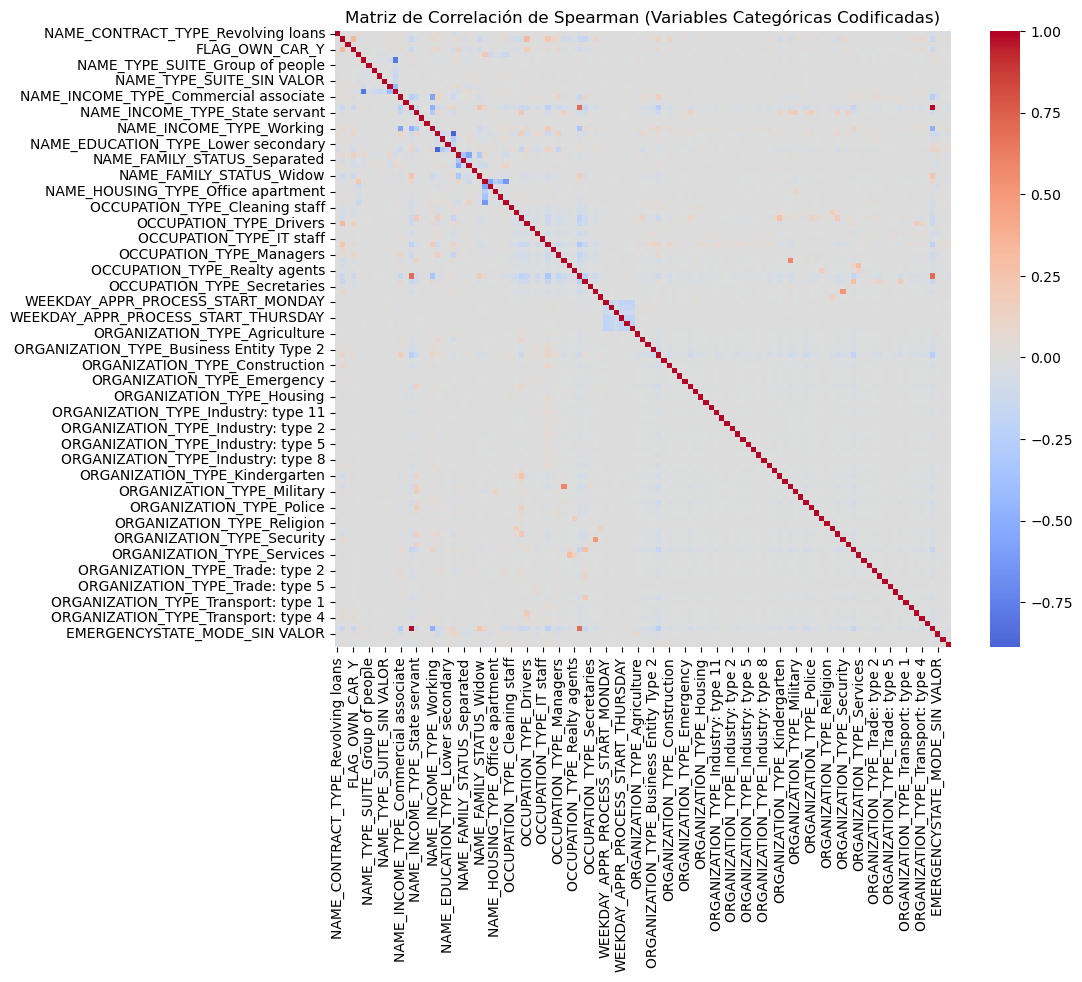

In [34]:
# Convertir variables categóricas en numéricas
data_train_encoded = pd.get_dummies(data_train[list_var_cat], drop_first=True)
data_train_spearman = pd.concat([data_train_encoded, data_train['TARGET']], axis=1)

# Calcular y graficar matriz de correlación de Spearman
plt.figure(figsize=(10, 8))
sns.heatmap(
    data_train_spearman.corr(method='spearman'), 
    annot=False, 
    cmap='coolwarm', 
    center=0, 
    square=True
)
plt.title("Matriz de Correlación de Spearman (Variables Categóricas Codificadas)")
plt.show()


##### __Variables con alta correlación positiva__
- Las variables relacionadas con tipos de organizaciones (ORGANIZATION_TYPE_...) presentan patrones de correlación entre algunas categorías específicas. Por ejemplo:

    - ORGANIZATION_TYPE_Industry: type 1, ORGANIZATION_TYPE_Industry: type 2, y otras categorías similares están relacionadas. Esto sugiere que los diferentes tipos de industria comparten características comunes en el dataset.

- Las categorías de estado civil y familia también muestran cierta correlación entre variables como:

    - NAME_FAMILY_STATUS_Separated, NAME_FAMILY_STATUS_Widow. Esto podría indicar que estos estados están relacionados con patrones comunes en los datos.

##### __Variables con baja correlación__
- Muchas variables categóricas relacionadas con días de la semana (WEEKDAY_APPR_PROCESS_START) no tienen correlaciones significativas con otras variables. Esto sugiere que estas variables podrían ser independientes en términos de información aportada.

##### __Correlaciones negativas notables__
- Existen algunas correlaciones negativas entre categorías relacionadas con ocupaciones (OCCUPATION_TYPE) y ciertos tipos de organización. Por ejemplo:

    - OCCUPATION_TYPE_Cleaning staff y algunos valores de ORGANIZATION_TYPE_... muestran relaciones negativas, lo que indica que estas ocupaciones no suelen asociarse con esas organizaciones.

##### __Áreas de interés para modelado__
- La categoría FLAG_OWN_CAR_Y (propietario de automóvil) muestra cierta correlación con variables como NAME_INCOME_TYPE_Working y otras relacionadas con ingresos y empleo. Esto podría ser relevante al modelar comportamientos financieros.

- Las categorías relacionadas con situaciones de emergencia (EMERGENCYSTATE_MODE) no tienen correlaciones significativas, lo que podría implicar que no aportan mucha información diferenciadora.

### 4. Guardar los conjuntos preprocesados

In [36]:
import os

output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)

data_train.to_csv(f"{output_dir}/train_pd_data_preprocessing_missing_outlier.csv", index=False)
data_test.to_csv(f"{output_dir}/test_pd_data_preprocessing_missing_outlier.csv", index=False)

print(f"Conjuntos preprocesados guardados en {output_dir}.")
print(f"Dimensiones del conjunto de entrenamiento: {data_train.shape}")
print(f"Dimensiones del conjunto de prueba: {data_test.shape}")

Conjuntos preprocesados guardados en ./data.
Dimensiones del conjunto de entrenamiento: (246008, 85)
Dimensiones del conjunto de prueba: (61503, 85)
